<a href="https://colab.research.google.com/github/meenalborkar/txt2Img/blob/main/flowers_GAN_final_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text to Image synthesis using DC-GAN
This notebook contains the Python and tensorflow code to generate flower images using the text prompts. We are using Oxford flowers dataset for this activity. The embeddings for text are generated using the glove approach. We are storing the preprocessed data, training data, testing data along with model parameters, model files etc. in Google Drive. The notebook is created in Google colab environment.

We have connected and used different execution/runtime environments with this notebook while the training happened. We found that CPU environment is super slow and TPU environment is the most effecient with respect to time needed for training the model.

# Getting Ready
Initializing the Google drive mount point and imports necessary libraries, packages for the execution.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import pandas as pd
import urllib.request
import imageio
import os
import numpy as np

from urllib.request import urlopen

We are using Stanford NLP group's GloVe embeddings approach to create the numerical/vector representation of text. Writing embeddings model is beyond scope of this project as our focus is on text to image synthesis. Therefore we have used the pretrained GloVe model. The embeddings model details can be found at: https://nlp.stanford.edu/projects/glove/

In [ ]:
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r',encoding="utf8")
    model = {}
    for line in f:
        try:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            model[word] = embedding
        except:
            print(word)
    print("Done.",len(model)," words loaded!")
    return model

In [ ]:
#Load the GloVe model using 40000 words
glove_embeddings = loadGloveModel("/content/drive/My Drive/glove_embeddings/glove.6B.300d.txt")

Loading Glove Model
Done. 400000  words loaded!


In [ ]:
# Setting up the paths
train_data_path = "/content/drive/My Drive/102flowers/102flowers"
train_images_path = "/content/drive/My Drive/102flowers/102flowers/jpg"
train_captions_path = "/content/drive/My Drive/102flowers/102flowers/text_c10/captions"

In [ ]:
# Importing packages
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Concatenate
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers
from sklearn.metrics import mean_squared_error

import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt

In [ ]:
# code for formatted time string. This will be used to name the files during training, testing, etc.
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In order to get good quality of images from the model, we need to feed it images with good resolution. This code section sets the values for the parameters which will be used during the training and testing configurations. Our implementation approach is focussed on pixel to pixel representation of images. All images must be square in shape, so we will specify the scaling accordingly. The resoultion will be applicable to both training and testing.

In [ ]:
GENERATE_RES = 2 # Generation resolution factor
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image - These parameters will be used while training the model. We are asking our model to generate png images made up of 28 images in each file.
#Hence we use the rows and cols representation.
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

#test image - These parameters will be used while generation/prediction phase of the model. We are asking our model to generate png images made up of 1 image in each file.
TEST_ROWS=1
TEST_COLS=1
TEST_MARGIN=16

# Size vector to generate images from
SEED_SIZE = 100
EMBEDDING_SIZE = 300

# environment variables providing paths and other paramenters for training and generation
DATA_PATH = train_images_path
MODEL_PATH = "/content/drive/My Drive/102flowers/102flowers/model"
EPOCHS = 50
BATCH_SIZE = 64
BUFFER_SIZE = 4000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 64px square images.


# Data Pre-Processing
In this section we have preprocessed our images data. After pre processing we created a buinary file so that we can reload it quickly as and when needed. There were 16000 images which we uploaded first in the Google drive's data folder and then created a binary file out of it. The dimensions of the image are encoded into the filename of the binary file because we need to regenerate it if these change.

In [ ]:
training_binary_path = os.path.join("/content/drive/My Drive/102flowers/102flowers/jpg/npy64",
                                    f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}_')

start = time.time()
print("Loading training images...")

training_data = []
flowers_path = sorted(os.listdir(DATA_PATH))

for filename in range(len(flowers_path)):
    path = os.path.join(DATA_PATH,flowers_path[filename])
    # print(path)
    try:
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      channel = np.asarray(image).shape[2]
      if channel == 3:
        training_data.append(np.asarray(image))
    except KeyboardInterrupt:
        print("Keyboard Interrup by me...")
        break
    except:
      pass
    if len(training_data) == 100:
      training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
                GENERATE_SQUARE,IMAGE_CHANNELS))
      training_data = training_data.astype(np.float32)
      #Normalizing the input
      training_data = training_data / 127.5 - 1.

      print("Saving training image " + str(100000 + filename) + ".npy")
      np.save(training_binary_path + str(100000 + filename) + ".npy",training_data)
      elapsed = time.time()-start
      print (f'Image preprocess time: {hms_string(elapsed)}')
      training_data = []
print("Complete")


Loading training images...


<ipython-input-11-5c2745b6b76f>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  GENERATE_SQUARE),Image.ANTIALIAS)


Saving training image 100100.npy
Image preprocess time: 0:02:46.23
Saving training image 100200.npy
Image preprocess time: 0:02:48.03
Saving training image 100300.npy
Image preprocess time: 0:02:50.03
Saving training image 100400.npy
Image preprocess time: 0:02:51.94
Saving training image 100500.npy
Image preprocess time: 0:02:53.87
Saving training image 100600.npy
Image preprocess time: 0:02:56.03
Saving training image 100700.npy
Image preprocess time: 0:02:58.29
Saving training image 100800.npy
Image preprocess time: 0:03:00.10
Saving training image 100900.npy
Image preprocess time: 0:03:01.86
Saving training image 101000.npy
Image preprocess time: 0:03:03.72
Saving training image 101100.npy
Image preprocess time: 0:03:05.69
Saving training image 101200.npy
Image preprocess time: 0:03:07.52
Saving training image 101300.npy
Image preprocess time: 0:03:09.37
Saving training image 101400.npy
Image preprocess time: 0:03:11.15
Saving training image 101500.npy
Image preprocess time: 0:03:1

# Captions Pre-processing
In this sestion, we will preprocess the .txt files which contain 5 captions for each image in the dataset. There are 8200+ caption files present. We created embeddings for captions using numpy function. For each 100 files in caption embeddings we added them with glove embedding to create more versatile embeddings representation. For simplicity we preprocess them and create a binary file. We can then load the captions data as and when needed.

In [ ]:
text_path = "/content/drive/My Drive/102flowers/102flowers/text_c10/captions"
text_files = sorted(os.listdir(text_path))
#print(text_files)
captions = []
caption_embeddings = np.zeros((len(text_files),300),dtype=np.float32)
for filename in range(len(text_files)):
    path = os.path.join(text_path,text_files[filename])
    #print(path)
    f = open(path,'r')
    data = f.read()
    data = data.split("\n")
    f.close()
    for d in range(1):
      x = data[d].lower()
      #x = x.replace(" ","")
      captions.append(x)
      count = 0
      for t in x:
        try:
          caption_embeddings[filename] += glove_embeddings[t]
          count += 1
        except:
          print(t)
          pass
      caption_embeddings[filename] /= count
    if filename %100 == 0:
      print("-------------Files completed:",filename)

स्ट्रीमिंग आउटपुट शेवटच्या 5000 ओळींपर्यंत ट्रंक केले.
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 

In [ ]:
# saving the caption embeddings numpy
embedding_binary_path = os.path.join('/content/drive/My Drive/102flowers/102flowers/jpg',
        f'embedding_data.npy')
print("Saving captions embeddings binary...")
np.save(embedding_binary_path,caption_embeddings)

Saving captions embeddings binary...


In [ ]:
# Creating a dataframe to store the captions
#df_captions = pd.DataFrame([])
#df_captions['captions'] = captions[:len(final_images)]

### Loading and combining numpys
In this section we will start preparing our data splits for training, testing etc.

In [ ]:
embedding_binary_path = os.path.join('/content/drive/My Drive/102flowers/102flowers/jpg',
        f'embedding_data.npy')

In [ ]:
caption_embeddings = np.load(embedding_binary_path)

In [ ]:
caption_embeddings.shape

(8209, 300)

In [ ]:
image_binary_path = "/content/drive/My Drive/102flowers/102flowers/jpg/npy64/"
images = os.listdir(image_binary_path)

In [ ]:
images[-1]

'training_data_64_64_108100.npy'

In [ ]:
# Creating a list of all the preprocessed images
final_images = np.load(image_binary_path + images[0])
for i in images[1:]:
  print(i)
  try:
    final_images = np.concatenate([final_images,np.load(image_binary_path + i)],axis = 0)
  except:
    pass

training_data_64_64_100300.npy
training_data_64_64_100200.npy
training_data_64_64_100400.npy
training_data_64_64_100500.npy
training_data_64_64_100600.npy
training_data_64_64_100700.npy
training_data_64_64_100800.npy
training_data_64_64_100900.npy
training_data_64_64_101000.npy
training_data_64_64_101100.npy
training_data_64_64_101200.npy
training_data_64_64_101300.npy
training_data_64_64_101400.npy
training_data_64_64_101500.npy
training_data_64_64_101600.npy
training_data_64_64_101700.npy
training_data_64_64_101800.npy
training_data_64_64_101900.npy
training_data_64_64_102000.npy
training_data_64_64_102100.npy
training_data_64_64_102200.npy
training_data_64_64_102300.npy
training_data_64_64_102400.npy
training_data_64_64_102500.npy
training_data_64_64_102600.npy
training_data_64_64_102700.npy
training_data_64_64_102800.npy
training_data_64_64_102900.npy
training_data_64_64_103000.npy
training_data_64_64_103100.npy
training_data_64_64_103200.npy
training_data_64_64_103300.npy
training

In [ ]:
# Creating a dataframe to store the captions
df_captions = pd.DataFrame([])
df_captions['captions'] = captions[:len(final_images)]

In [ ]:
df_captions.head()

,captions
0,"prominent purple stigma,petals are white inc olor"
1,"this flower is blue and green in color, with p..."
2,"outer petals are green in color and klarger,in..."
3,"there are several shapes, sizes, and colors of..."
4,the stamen are towering over the stigma which ...


In [ ]:
captions[:10]

['prominent purple stigma,petals are white inc olor',
 'this flower is blue and green in color, with petals that are oval shaped.',
 'outer petals are green in color and klarger,inner petals are needle shaped',
 'there are several shapes, sizes, and colors of petals on this complex flower.',
 'the stamen are towering over the stigma which cannot be seen.',
 'this flower is white and purple in color, with petals that are oval shaped.',
 'the petals of this flower are green with a long stigma',
 'the blossom has a layer of rounded purple and white petals topped by a layer of fringed purple petals.',
 'this flower is purple and yellow in color, with petals that are oval shaped.',
 'the petals on this flower are white with an elaborate pistil.']

In [ ]:
df_captions.to_csv("/content/drive/My Drive/102flowers/102flowers/text_c10/captions.csv",index=None)


In [ ]:
final_images.shape


(8100, 64, 64, 3)

In [ ]:
df_captions= pd.read_csv("/content/drive/My Drive/102flowers/102flowers/text_c10/captions.csv")

In [ ]:
df_captions.head()


,captions
0,"prominent purple stigma,petals are white inc olor"
1,"this flower is blue and green in color, with p..."
2,"outer petals are green in color and klarger,in..."
3,"there are several shapes, sizes, and colors of..."
4,the stamen are towering over the stigma which ...


In [ ]:
len(captions)

8209

In [ ]:
#images for testing
save_images_captions = captions[:28].copy()
save_images_embeddings = np.copy(caption_embeddings[:28])
save_images_npy = np.copy(final_images[:28])

In [ ]:
caption_embeddings = caption_embeddings[:final_images.shape[0]]

In [ ]:
caption_embeddings.shape

(8100, 300)

In [ ]:
#shuffling the data for training data set
p = np.random.permutation(len(final_images))

In [ ]:
final_images_shuffled = final_images[p]
final_embeddings_shuffled = caption_embeddings[p]


In [ ]:
final_images_shuffled.shape


(8100, 64, 64, 3)

In [ ]:
final_embeddings_shuffled.shape


(8100, 300)

In [ ]:
# Batch and shuffle the data
# train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
#     .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices({'images': final_images,
                                                    'embeddings': caption_embeddings}).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


# Data Modeling
In this section we start working on core concepts of DC-GAN. We will define  the Generator and Discriminator functions. These functions use multipleactivation functions to bring non linearity in the implementation of model.

In [ ]:
def build_generator_func(seed_size,embedding_size, channels):
  input_seed = Input(shape=seed_size)
  input_embed = Input(shape = embedding_size)
  d0 = Dense(128)(input_embed)
  leaky0 = LeakyReLU(alpha=0.2)(d0)

  merge = Concatenate()([input_seed, leaky0])

  d1 = Dense(4*4*256,activation="relu")(merge)
  reshape = Reshape((4,4,256))(d1)

  upSamp1 = UpSampling2D()(reshape)
  conv2d1 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp1)
  batchNorm1 = BatchNormalization(momentum=0.8)(conv2d1)
  leaky1 = LeakyReLU(alpha=0.2)(batchNorm1)

  upSamp2 = UpSampling2D()(leaky1)
  conv2d2 = Conv2DTranspose(256,kernel_size=5,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  upSamp3 = UpSampling2D()(leaky2)
  conv2d3 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  upSamp4 = UpSampling2D(size=(GENERATE_RES,GENERATE_RES))(leaky3)
  conv2d4 = Conv2DTranspose(128,kernel_size=4,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(upSamp4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  outputConv = Conv2DTranspose(channels,kernel_size=3,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(leaky4)
  outputActi = Activation("tanh")(outputConv)

  model = Model(inputs=[input_seed,input_embed], outputs=outputActi)
  return model

In [ ]:
def build_discriminator_func(image_shape, embedding_size):
  input_shape = Input(shape=image_shape)
  input_embed = Input(shape=embedding_size)

  conv2d1 = Conv2D(32,kernel_size=4,strides=2,input_shape=image_shape,padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_shape)
  leaky1 = LeakyReLU(alpha=0.2)(conv2d1)

  drop2 = Dropout(0.25)(leaky1)
  conv2d2 = Conv2D(64, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop2)
  # zero2 = ZeroPadding2D(padding=((0,1),(0,1)))(conv2d2)
  batchNorm2 = BatchNormalization(momentum=0.8)(conv2d2)
  leaky2 = LeakyReLU(alpha=0.2)(batchNorm2)

  drop3 = Dropout(0.25)(leaky2)
  conv2d3 = Conv2D(128, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop3)
  batchNorm3 = BatchNormalization(momentum=0.8)(conv2d3)
  leaky3 = LeakyReLU(alpha=0.2)(batchNorm3)

  drop4 = Dropout(0.25)(leaky3)
  conv2d4 = Conv2D(256, kernel_size=4, strides=2, padding="same",kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop4)
  batchNorm4 = BatchNormalization(momentum=0.8)(conv2d4)
  leaky4 = LeakyReLU(alpha=0.2)(batchNorm4)

  dense_embed = Dense(128,kernel_initializer=initializers.RandomNormal(stddev=0.02))(input_embed)
  leaky_embed = LeakyReLU(alpha=0.2)(dense_embed)
  reshape_embed = Reshape((4,4,8))(leaky_embed)
  merge_embed = Concatenate()([leaky4, reshape_embed])

  drop5 = Dropout(0.25)(merge_embed)
  conv2d5 = Conv2D(512, kernel_size=4,kernel_initializer=initializers.RandomNormal(stddev=0.02))(drop5)
  batchNorm5 = BatchNormalization(momentum=0.8)(conv2d5)
  leaky5 = LeakyReLU(alpha=0.2)(batchNorm5)

  drop6 = Dropout(0.25)(leaky5)
  flatten = Flatten()(drop6)
  output = Dense(1,activation="sigmoid")(flatten)

  model = Model(inputs=[input_shape,input_embed], outputs=output)
  return model

In [ ]:
#Function to save image samples generated
def save_images(cnt,noise,embeds):
  image_array = np.full((
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)),
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3),
      255, dtype=np.uint8)

  generated_images = generator.predict((noise,embeds))

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1


  output_path = "/content/drive/My Drive/102flowers/102flowers/images_generated_during_training_1000"
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [ ]:
# Initlializing a generator
generator = build_generator_func(SEED_SIZE,EMBEDDING_SIZE, IMAGE_CHANNELS)
generator.load_weights("/content/drive/My Drive/102flowers/102flowers/model/text_to_image_generator_cub_character.h5")

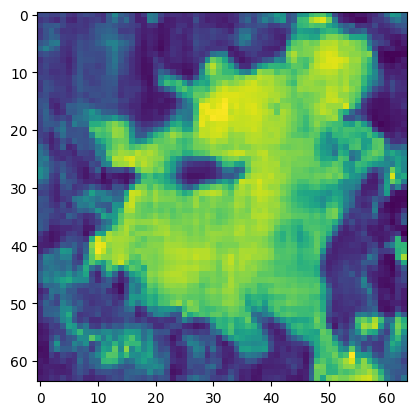

In [ ]:
# Sample output from the Generator
noise = tf.random.normal([1, 100])
generated_image = generator((noise,caption_embeddings[5].reshape(1,300)), training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
# Initlializing a discriminator
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator_func(image_shape,EMBEDDING_SIZE)
discriminator.load_weights("/content/drive/My Drive/102flowers/102flowers/model/text_to_image_disc_cub_character.h5")

In [ ]:
decision = discriminator((generated_image,caption_embeddings[5].reshape(1,300)))
print(decision)

tf.Tensor([[0.20191868]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text):
    real_loss = cross_entropy(tf.random.uniform(real_image_real_text.shape,0.8,1.0), real_image_real_text)
    fake_loss = (cross_entropy(tf.random.uniform(fake_image_real_text.shape,0.0,0.2), fake_image_real_text) +
                 cross_entropy(tf.random.uniform(real_image_fake_text.shape,0.0,0.2), real_image_fake_text))/2

    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Both the generator and discriminator use Adam and the same learning rate and momentum. This does not need to be the case. If you use a **GENERATE_RES** greater than 3 you may need to tune these learning rates, as well as other training and hyperparameters.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2.0e-4,beta_1 = 0.5)

## Training the model

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,captions,fake_captions):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE],dtype=tf.float32)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator((seed,captions), training=True)
    real_image_real_text = discriminator((images,captions), training=True)
    real_image_fake_text = discriminator((images,fake_captions), training=True)
    fake_image_real_text = discriminator((generated_images,captions), training=True)

    gen_loss = generator_loss(fake_image_real_text)
    disc_loss = discriminator_loss(real_image_real_text, fake_image_real_text, real_image_fake_text)
    # print(gen_loss)
    # print(disc_loss)

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator,
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [ ]:
# Function that executes trianing process
def train(train_dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS,
                                       SEED_SIZE))
  fixed_embed = save_images_embeddings

  start = time.time()

  for epoch in range(epochs):
    print("epoch start...")
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for batch in train_dataset[:-1]:
      train_batch = batch['images']
      caption_batch = batch['embeddings']

      fake_caption_batch = np.copy(caption_batch)
      np.random.shuffle(fake_caption_batch)

      t = train_step(train_batch,caption_batch,fake_caption_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])
    print("now")
    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print(f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed,fixed_embed)

    generator.save(os.path.join(MODEL_PATH,"text_to_image_generator_cub_character.h5"))
    discriminator.save(os.path.join(MODEL_PATH,"text_to_image_disc_cub_character.h5"))
    print("model saved")

In [ ]:
train(list(train_dataset.as_numpy_iterator()), 1000)

epoch start...
now
Epoch 1, gen loss=1.417976975440979,disc loss=1.1559722423553467, 0:00:10.28
1/1 [==============================] - 0s 202ms/step


model saved
epoch start...
now
Epoch 2, gen loss=1.3062129020690918,disc loss=1.1561769247055054, 0:00:03.11
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 3, gen loss=1.2776546478271484,disc loss=1.1426267623901367, 0:00:03.09
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 4, gen loss=1.3563096523284912,disc loss=1.1284594535827637, 0:00:03.10
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 5, gen loss=1.2954047918319702,disc loss=1.1372756958007812, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 6, gen loss=1.2927837371826172,disc loss=1.127961277961731, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 7, gen loss=1.373173713684082,disc loss=1.1108789443969727, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 8, gen loss=1.3695659637451172,disc loss=1.1237187385559082, 0:00:03.10
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 9, gen loss=1.452960729598999,disc loss=1.0944796800613403, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 10, gen loss=1.3865280151367188,disc loss=1.125881552696228, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 11, gen loss=1.3924826383590698,disc loss=1.105789065361023, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 12, gen loss=1.482513189315796,disc loss=1.1032027006149292, 0:00:03.09
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 13, gen loss=1.5142208337783813,disc loss=1.0718705654144287, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 14, gen loss=1.3849917650222778,disc loss=1.1023861169815063, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 15, gen loss=1.4625312089920044,disc loss=1.0841585397720337, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 16, gen loss=1.4515380859375,disc loss=1.0895380973815918, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 17, gen loss=1.4281384944915771,disc loss=1.0909759998321533, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 18, gen loss=1.3440535068511963,disc loss=1.1157368421554565, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 19, gen loss=1.3550450801849365,disc loss=1.1134734153747559, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 20, gen loss=1.358642816543579,disc loss=1.1047310829162598, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 21, gen loss=1.3678971529006958,disc loss=1.1004806756973267, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 22, gen loss=1.3316248655319214,disc loss=1.1035138368606567, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 23, gen loss=1.4121804237365723,disc loss=1.0978409051895142, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 24, gen loss=1.4196175336837769,disc loss=1.089924931526184, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 25, gen loss=1.459459662437439,disc loss=1.095665454864502, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 26, gen loss=1.4126133918762207,disc loss=1.0865472555160522, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 27, gen loss=1.3994511365890503,disc loss=1.0793590545654297, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 28, gen loss=1.4312764406204224,disc loss=1.0867819786071777, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 29, gen loss=1.5006617307662964,disc loss=1.0758365392684937, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 30, gen loss=1.3721216917037964,disc loss=1.0960371494293213, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 31, gen loss=1.385818362236023,disc loss=1.0881308317184448, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 32, gen loss=1.3342539072036743,disc loss=1.1049065589904785, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 33, gen loss=1.3746013641357422,disc loss=1.092076063156128, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 34, gen loss=1.4411228895187378,disc loss=1.0782924890518188, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 35, gen loss=1.390724778175354,disc loss=1.0774084329605103, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 36, gen loss=1.395038366317749,disc loss=1.1012463569641113, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 37, gen loss=1.3350309133529663,disc loss=1.0938019752502441, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 38, gen loss=1.3711508512496948,disc loss=1.1051949262619019, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 39, gen loss=1.3182002305984497,disc loss=1.0990548133850098, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 40, gen loss=1.3538124561309814,disc loss=1.0915043354034424, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 41, gen loss=1.369794487953186,disc loss=1.089614748954773, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 42, gen loss=1.3486883640289307,disc loss=1.0788649320602417, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 43, gen loss=1.4589606523513794,disc loss=1.0708295106887817, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 44, gen loss=1.4006638526916504,disc loss=1.0748668909072876, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 45, gen loss=1.3760676383972168,disc loss=1.0845472812652588, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 46, gen loss=1.3780208826065063,disc loss=1.0766490697860718, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 47, gen loss=1.4545880556106567,disc loss=1.0755131244659424, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 48, gen loss=1.4169808626174927,disc loss=1.0677982568740845, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 49, gen loss=1.4861315488815308,disc loss=1.0537521839141846, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 50, gen loss=1.4608618021011353,disc loss=1.0793688297271729, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 51, gen loss=1.4372111558914185,disc loss=1.0741599798202515, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 52, gen loss=1.3939235210418701,disc loss=1.0861350297927856, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 53, gen loss=1.4744391441345215,disc loss=1.0664341449737549, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 54, gen loss=1.4997564554214478,disc loss=1.0479320287704468, 0:00:03.10
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 55, gen loss=1.4134989976882935,disc loss=1.073296070098877, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 56, gen loss=1.412845253944397,disc loss=1.082574486732483, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 57, gen loss=1.3829891681671143,disc loss=1.0854427814483643, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 58, gen loss=1.4448833465576172,disc loss=1.061434268951416, 0:00:03.10
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 59, gen loss=1.4610648155212402,disc loss=1.0667030811309814, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 60, gen loss=1.5501559972763062,disc loss=1.0606544017791748, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 61, gen loss=1.5528994798660278,disc loss=1.0655317306518555, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 62, gen loss=1.6008309125900269,disc loss=1.0494139194488525, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 63, gen loss=1.492112159729004,disc loss=1.058186650276184, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 64, gen loss=1.4146583080291748,disc loss=1.0703741312026978, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 65, gen loss=1.4368245601654053,disc loss=1.0614229440689087, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 66, gen loss=1.4994516372680664,disc loss=1.0501855611801147, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 67, gen loss=1.420372724533081,disc loss=1.0672303438186646, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 68, gen loss=1.4324270486831665,disc loss=1.0705252885818481, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 69, gen loss=1.5441306829452515,disc loss=1.043164849281311, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 70, gen loss=1.5045772790908813,disc loss=1.0520488023757935, 0:00:03.14
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 71, gen loss=1.4028645753860474,disc loss=1.0639041662216187, 0:00:03.10
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 72, gen loss=1.506354808807373,disc loss=1.0546040534973145, 0:00:03.06
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 73, gen loss=1.4045339822769165,disc loss=1.0698543787002563, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 74, gen loss=1.4632701873779297,disc loss=1.0710113048553467, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 75, gen loss=1.448089838027954,disc loss=1.059125304222107, 0:00:03.10
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 76, gen loss=1.5153963565826416,disc loss=1.061879277229309, 0:00:03.08
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 77, gen loss=1.4216289520263672,disc loss=1.0638705492019653, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 78, gen loss=1.4502849578857422,disc loss=1.0675779581069946, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 79, gen loss=1.4235255718231201,disc loss=1.0556293725967407, 0:00:03.10
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 80, gen loss=1.4047220945358276,disc loss=1.072721242904663, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 81, gen loss=1.468912959098816,disc loss=1.0640509128570557, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 82, gen loss=1.4958778619766235,disc loss=1.0443925857543945, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 83, gen loss=1.5437036752700806,disc loss=1.0444400310516357, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 84, gen loss=1.3701530694961548,disc loss=1.0753854513168335, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 85, gen loss=1.399139165878296,disc loss=1.0610148906707764, 0:00:03.06
1/1 [==============================] - 0s 19ms/step


model saved
epoch start...
now
Epoch 86, gen loss=1.4216910600662231,disc loss=1.0730057954788208, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 87, gen loss=1.3678193092346191,disc loss=1.074390172958374, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 88, gen loss=1.4190566539764404,disc loss=1.0650486946105957, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 89, gen loss=1.4263992309570312,disc loss=1.0648812055587769, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 90, gen loss=1.5434479713439941,disc loss=1.0363353490829468, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 91, gen loss=1.5735666751861572,disc loss=1.018973469734192, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 92, gen loss=1.5845649242401123,disc loss=1.0358607769012451, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 93, gen loss=1.4813019037246704,disc loss=1.0482738018035889, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 94, gen loss=1.455498456954956,disc loss=1.0500810146331787, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 95, gen loss=1.4448233842849731,disc loss=1.0555700063705444, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 96, gen loss=1.4503306150436401,disc loss=1.0446646213531494, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 97, gen loss=1.4818487167358398,disc loss=1.0587608814239502, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 98, gen loss=1.6325217485427856,disc loss=1.030340313911438, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 99, gen loss=1.5230118036270142,disc loss=1.0403046607971191, 0:00:03.08
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 100, gen loss=1.5073989629745483,disc loss=1.0405610799789429, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 101, gen loss=1.505256175994873,disc loss=1.0414807796478271, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 102, gen loss=1.4781776666641235,disc loss=1.0528498888015747, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 103, gen loss=1.505136489868164,disc loss=1.039731502532959, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 104, gen loss=1.5525068044662476,disc loss=1.0301244258880615, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 105, gen loss=1.6501418352127075,disc loss=1.0246905088424683, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 106, gen loss=1.6277939081192017,disc loss=1.0243417024612427, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 107, gen loss=1.7251883745193481,disc loss=1.0159757137298584, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 108, gen loss=1.6380724906921387,disc loss=1.0334153175354004, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 109, gen loss=1.602497935295105,disc loss=1.0312411785125732, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 110, gen loss=1.515000820159912,disc loss=1.043670415878296, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 111, gen loss=1.4297125339508057,disc loss=1.0700329542160034, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 112, gen loss=1.485949158668518,disc loss=1.0497064590454102, 0:00:03.10
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 113, gen loss=1.5265228748321533,disc loss=1.0308480262756348, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 114, gen loss=1.618515968322754,disc loss=1.010433554649353, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 115, gen loss=1.491492509841919,disc loss=1.0541437864303589, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 116, gen loss=1.557738184928894,disc loss=1.0348306894302368, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 117, gen loss=1.517006278038025,disc loss=1.0587232112884521, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 118, gen loss=1.5594574213027954,disc loss=1.0187073945999146, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 119, gen loss=1.502949833869934,disc loss=1.0340062379837036, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 120, gen loss=1.5964384078979492,disc loss=1.0167052745819092, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 121, gen loss=1.552909016609192,disc loss=1.0216197967529297, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 122, gen loss=1.5363281965255737,disc loss=1.0382287502288818, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 123, gen loss=1.5438175201416016,disc loss=1.0308802127838135, 0:00:03.06
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 124, gen loss=1.5708307027816772,disc loss=1.0218499898910522, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 125, gen loss=1.508919596672058,disc loss=1.0401252508163452, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 126, gen loss=1.4918986558914185,disc loss=1.0482488870620728, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 127, gen loss=1.5274949073791504,disc loss=1.037954330444336, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 128, gen loss=1.5661205053329468,disc loss=1.0303667783737183, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 129, gen loss=1.5947879552841187,disc loss=1.0212738513946533, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 130, gen loss=1.6946265697479248,disc loss=1.0059281587600708, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 131, gen loss=1.5491621494293213,disc loss=1.034188985824585, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 132, gen loss=1.5975397825241089,disc loss=1.0223294496536255, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 133, gen loss=1.5511332750320435,disc loss=1.0308586359024048, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 134, gen loss=1.6401103734970093,disc loss=1.0210046768188477, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 135, gen loss=1.4654120206832886,disc loss=1.0471949577331543, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 136, gen loss=1.6064473390579224,disc loss=1.024965524673462, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 137, gen loss=1.6298143863677979,disc loss=1.018866777420044, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 138, gen loss=1.603636622428894,disc loss=1.0162829160690308, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 139, gen loss=1.5785986185073853,disc loss=1.013858437538147, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 140, gen loss=1.5880844593048096,disc loss=1.0186152458190918, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 141, gen loss=1.5460072755813599,disc loss=1.0422885417938232, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 142, gen loss=1.6492990255355835,disc loss=1.006201148033142, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 143, gen loss=1.6095143556594849,disc loss=1.0138524770736694, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 144, gen loss=1.6319937705993652,disc loss=1.0077686309814453, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 145, gen loss=1.5382554531097412,disc loss=1.0371536016464233, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 146, gen loss=1.5798115730285645,disc loss=1.0269078016281128, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 147, gen loss=1.528127670288086,disc loss=1.0274440050125122, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 148, gen loss=1.545244812965393,disc loss=1.022786021232605, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 149, gen loss=1.6878775358200073,disc loss=0.9958080053329468, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 150, gen loss=1.5308417081832886,disc loss=1.0277923345565796, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 151, gen loss=1.482865333557129,disc loss=1.0310648679733276, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 152, gen loss=1.4894137382507324,disc loss=1.0403220653533936, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 153, gen loss=1.5458437204360962,disc loss=1.0260242223739624, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 154, gen loss=1.7157407999038696,disc loss=0.9894382357597351, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 155, gen loss=1.5521652698516846,disc loss=1.020316243171692, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 156, gen loss=1.653395175933838,disc loss=1.0098226070404053, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 157, gen loss=1.7159876823425293,disc loss=0.9899835586547852, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 158, gen loss=1.6603057384490967,disc loss=1.004888653755188, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 159, gen loss=1.6869844198226929,disc loss=0.9908931851387024, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 160, gen loss=1.6953117847442627,disc loss=1.0008230209350586, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 161, gen loss=1.6793657541275024,disc loss=0.989859938621521, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 162, gen loss=1.7990237474441528,disc loss=0.9855082631111145, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 163, gen loss=1.59792160987854,disc loss=1.0142710208892822, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 164, gen loss=1.5079526901245117,disc loss=1.0206907987594604, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 165, gen loss=1.5605140924453735,disc loss=1.0075806379318237, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 166, gen loss=1.5642414093017578,disc loss=1.0195753574371338, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 167, gen loss=1.692739725112915,disc loss=0.9920337200164795, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 168, gen loss=1.6643702983856201,disc loss=0.9911506175994873, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 169, gen loss=1.7047330141067505,disc loss=0.9967820048332214, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 170, gen loss=1.6187372207641602,disc loss=1.0064465999603271, 0:00:03.10
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 171, gen loss=1.6003377437591553,disc loss=1.0014026165008545, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 172, gen loss=1.595263957977295,disc loss=1.0117312669754028, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 173, gen loss=1.5646588802337646,disc loss=1.0202561616897583, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 174, gen loss=1.5584619045257568,disc loss=1.028457760810852, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 175, gen loss=1.5754097700119019,disc loss=1.0189076662063599, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 176, gen loss=1.5915380716323853,disc loss=1.001158356666565, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 177, gen loss=1.7125359773635864,disc loss=0.9972769021987915, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 178, gen loss=1.748587727546692,disc loss=0.9795605540275574, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 179, gen loss=1.6883001327514648,disc loss=1.0060603618621826, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 180, gen loss=1.6055097579956055,disc loss=1.0122888088226318, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 181, gen loss=1.5723110437393188,disc loss=1.0069355964660645, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 182, gen loss=1.6228512525558472,disc loss=1.0004147291183472, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 183, gen loss=1.6355020999908447,disc loss=1.0010851621627808, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 184, gen loss=1.7646726369857788,disc loss=0.9867204427719116, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 185, gen loss=1.6409733295440674,disc loss=0.9871771335601807, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 186, gen loss=1.523061752319336,disc loss=1.017042636871338, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 187, gen loss=1.5604363679885864,disc loss=1.0219718217849731, 0:00:03.14
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 188, gen loss=1.575494647026062,disc loss=1.0092252492904663, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 189, gen loss=1.573718786239624,disc loss=1.0203566551208496, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 190, gen loss=1.5124390125274658,disc loss=1.0117478370666504, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 191, gen loss=1.6779807806015015,disc loss=0.9853346943855286, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 192, gen loss=1.6095499992370605,disc loss=1.006500482559204, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 193, gen loss=1.5211280584335327,disc loss=1.0122194290161133, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 194, gen loss=1.6452642679214478,disc loss=1.0079052448272705, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 195, gen loss=1.6984878778457642,disc loss=1.000367522239685, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 196, gen loss=1.742937684059143,disc loss=0.986093282699585, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 197, gen loss=1.6503751277923584,disc loss=0.996737539768219, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 198, gen loss=1.7074675559997559,disc loss=0.9858094453811646, 0:00:03.10
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 199, gen loss=1.5872677564620972,disc loss=1.0008976459503174, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 200, gen loss=1.672022819519043,disc loss=0.9948946237564087, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 201, gen loss=1.6427412033081055,disc loss=0.9910292029380798, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 202, gen loss=1.5796234607696533,disc loss=1.0150022506713867, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 203, gen loss=1.6730625629425049,disc loss=0.9885959029197693, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 204, gen loss=1.7211097478866577,disc loss=0.9746028184890747, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 205, gen loss=1.6795811653137207,disc loss=0.9741658568382263, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 206, gen loss=1.6609604358673096,disc loss=1.0021837949752808, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 207, gen loss=1.659494400024414,disc loss=0.9974752068519592, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 208, gen loss=1.657186508178711,disc loss=1.0028269290924072, 0:00:03.06
1/1 [==============================] - 0s 34ms/step


model saved
epoch start...
now
Epoch 209, gen loss=1.6779534816741943,disc loss=0.9858508706092834, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 210, gen loss=1.6977612972259521,disc loss=0.9938920140266418, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 211, gen loss=1.5938650369644165,disc loss=0.9998217225074768, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 212, gen loss=1.5924443006515503,disc loss=1.01004159450531, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 213, gen loss=1.5850173234939575,disc loss=1.004643201828003, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 214, gen loss=1.5323907136917114,disc loss=1.020579218864441, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 215, gen loss=1.6572517156600952,disc loss=1.0018587112426758, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 216, gen loss=1.7010912895202637,disc loss=0.9899824261665344, 0:00:03.10
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 217, gen loss=1.665668249130249,disc loss=0.988201916217804, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 218, gen loss=1.6299083232879639,disc loss=0.9962900876998901, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 219, gen loss=1.6429349184036255,disc loss=0.9853883385658264, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 220, gen loss=1.7115706205368042,disc loss=0.9818077087402344, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 221, gen loss=1.7033967971801758,disc loss=0.9850611686706543, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 222, gen loss=1.8181922435760498,disc loss=0.9706749320030212, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 223, gen loss=1.713731288909912,disc loss=0.9890955090522766, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 224, gen loss=1.7170546054840088,disc loss=0.9825165867805481, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 225, gen loss=1.8984293937683105,disc loss=0.9571052193641663, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 226, gen loss=1.7863229513168335,disc loss=0.9578744173049927, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 227, gen loss=1.7543424367904663,disc loss=0.964791476726532, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 228, gen loss=1.7795400619506836,disc loss=0.956312894821167, 0:00:03.10
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 229, gen loss=1.8543641567230225,disc loss=0.9474897384643555, 0:00:03.11
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 230, gen loss=1.7792332172393799,disc loss=0.9672131538391113, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 231, gen loss=1.788143515586853,disc loss=0.9779220223426819, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 232, gen loss=1.8670949935913086,disc loss=0.9552162289619446, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 233, gen loss=1.7550169229507446,disc loss=0.966866672039032, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 234, gen loss=1.7416141033172607,disc loss=0.9795268177986145, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 235, gen loss=1.7836787700653076,disc loss=0.975277841091156, 0:00:03.10
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 236, gen loss=1.8143831491470337,disc loss=0.9516494870185852, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 237, gen loss=1.824468731880188,disc loss=0.9684479236602783, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 238, gen loss=1.7497501373291016,disc loss=0.9763836860656738, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 239, gen loss=1.7632396221160889,disc loss=0.9827030301094055, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 240, gen loss=1.8228822946548462,disc loss=0.9643006920814514, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 241, gen loss=1.750508427619934,disc loss=0.9648860096931458, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 242, gen loss=1.7622811794281006,disc loss=0.9554069638252258, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 243, gen loss=1.7813656330108643,disc loss=0.963864266872406, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 244, gen loss=1.7312372922897339,disc loss=0.9830427765846252, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 245, gen loss=1.7667242288589478,disc loss=0.9848511219024658, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 246, gen loss=1.8670685291290283,disc loss=0.9587334394454956, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 247, gen loss=1.7213994264602661,disc loss=0.9800200462341309, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 248, gen loss=1.7236311435699463,disc loss=0.9811770915985107, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 249, gen loss=1.7325446605682373,disc loss=0.9695756435394287, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 250, gen loss=1.7440922260284424,disc loss=0.9678892493247986, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 251, gen loss=1.789395809173584,disc loss=0.9513086080551147, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 252, gen loss=1.8070127964019775,disc loss=0.9612353444099426, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 253, gen loss=1.8179376125335693,disc loss=0.9525151252746582, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 254, gen loss=1.772284746170044,disc loss=0.9577802419662476, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 255, gen loss=1.72481369972229,disc loss=0.973307728767395, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 256, gen loss=1.6782019138336182,disc loss=0.9787083268165588, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 257, gen loss=1.7123585939407349,disc loss=0.980677604675293, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 258, gen loss=1.7188020944595337,disc loss=0.9764944314956665, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 259, gen loss=1.8148343563079834,disc loss=0.9643325209617615, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 260, gen loss=1.8092496395111084,disc loss=0.9602293372154236, 0:00:03.10
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 261, gen loss=1.8299561738967896,disc loss=0.9650899767875671, 0:00:03.10
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 262, gen loss=1.7593313455581665,disc loss=0.968036949634552, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 263, gen loss=1.678638219833374,disc loss=0.976108968257904, 0:00:03.10
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 264, gen loss=1.6543635129928589,disc loss=0.970160961151123, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 265, gen loss=1.731722116470337,disc loss=0.9695319533348083, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 266, gen loss=1.8347218036651611,disc loss=0.9581380486488342, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 267, gen loss=1.8323273658752441,disc loss=0.9544942378997803, 0:00:03.11
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 268, gen loss=1.7695351839065552,disc loss=0.9535343647003174, 0:00:03.12
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 269, gen loss=1.7362436056137085,disc loss=0.9552921056747437, 0:00:03.11
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 270, gen loss=1.7523775100708008,disc loss=0.9681654572486877, 0:00:03.13
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 271, gen loss=1.8143723011016846,disc loss=0.958196222782135, 0:00:03.11
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 272, gen loss=1.74245023727417,disc loss=0.9663473963737488, 0:00:03.13
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 273, gen loss=1.8185473680496216,disc loss=0.9563563466072083, 0:00:03.14
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 274, gen loss=1.7965059280395508,disc loss=0.9587960839271545, 0:00:03.16
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 275, gen loss=1.8406988382339478,disc loss=0.9557019472122192, 0:00:03.13
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 276, gen loss=1.7579083442687988,disc loss=0.9744227528572083, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 277, gen loss=1.7613738775253296,disc loss=0.9591021537780762, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 278, gen loss=1.8471274375915527,disc loss=0.9589914083480835, 0:00:03.08
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 279, gen loss=1.6891108751296997,disc loss=0.9739249348640442, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 280, gen loss=1.7961000204086304,disc loss=0.9607518911361694, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 281, gen loss=1.6546874046325684,disc loss=0.9923333525657654, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 282, gen loss=1.7662127017974854,disc loss=0.9746967554092407, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 283, gen loss=1.7092889547348022,disc loss=0.9701686501502991, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 284, gen loss=1.6550315618515015,disc loss=0.9802926778793335, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 285, gen loss=1.8312445878982544,disc loss=0.9459328651428223, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 286, gen loss=1.7789249420166016,disc loss=0.9665952920913696, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 287, gen loss=2.004952907562256,disc loss=0.9432381391525269, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 288, gen loss=2.0186824798583984,disc loss=0.9285300374031067, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 289, gen loss=1.88102126121521,disc loss=0.9397063851356506, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 290, gen loss=1.8376545906066895,disc loss=0.9522267580032349, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 291, gen loss=1.9222896099090576,disc loss=0.934874415397644, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 292, gen loss=1.9414726495742798,disc loss=0.9462789297103882, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 293, gen loss=1.8134245872497559,disc loss=0.9458311200141907, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 294, gen loss=1.9325929880142212,disc loss=0.9425352811813354, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 295, gen loss=1.8742358684539795,disc loss=0.9453948736190796, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 296, gen loss=1.7665377855300903,disc loss=0.9579446315765381, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 297, gen loss=1.8022198677062988,disc loss=0.9562138319015503, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 298, gen loss=1.8270469903945923,disc loss=0.9472318887710571, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 299, gen loss=1.8112684488296509,disc loss=0.9425833225250244, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 300, gen loss=1.7453094720840454,disc loss=0.9637912511825562, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 301, gen loss=1.7558119297027588,disc loss=0.9758595824241638, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 302, gen loss=1.759024977684021,disc loss=0.9650426506996155, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 303, gen loss=1.719902753829956,disc loss=0.9697065353393555, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 304, gen loss=1.7837629318237305,disc loss=0.9445903897285461, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 305, gen loss=1.7741047143936157,disc loss=0.9419477581977844, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 306, gen loss=1.831449270248413,disc loss=0.9462581276893616, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 307, gen loss=1.865297555923462,disc loss=0.9508111476898193, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 308, gen loss=1.8748927116394043,disc loss=0.9493404030799866, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 309, gen loss=1.8127225637435913,disc loss=0.9560584425926208, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 310, gen loss=1.8024805784225464,disc loss=0.9535356163978577, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 311, gen loss=1.7974239587783813,disc loss=0.9499943852424622, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 312, gen loss=1.8159586191177368,disc loss=0.9671143889427185, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 313, gen loss=1.7465224266052246,disc loss=0.9511318802833557, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 314, gen loss=1.8136996030807495,disc loss=0.9603656530380249, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 315, gen loss=1.8523025512695312,disc loss=0.9469959735870361, 0:00:03.10
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 316, gen loss=1.9601572751998901,disc loss=0.9306418299674988, 0:00:03.08
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 317, gen loss=1.8227483034133911,disc loss=0.9447841048240662, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 318, gen loss=1.8366916179656982,disc loss=0.9504749178886414, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 319, gen loss=1.7895784378051758,disc loss=0.9542475342750549, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 320, gen loss=1.7043840885162354,disc loss=0.9731573462486267, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 321, gen loss=1.6941155195236206,disc loss=0.9711574912071228, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 322, gen loss=1.892077922821045,disc loss=0.953974187374115, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 323, gen loss=1.6901320219039917,disc loss=0.9785237312316895, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 324, gen loss=1.686455249786377,disc loss=0.966841459274292, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 325, gen loss=1.7503877878189087,disc loss=0.9596313834190369, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 326, gen loss=1.7387096881866455,disc loss=0.9665071964263916, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 327, gen loss=1.6672266721725464,disc loss=0.9787759184837341, 0:00:03.10
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 328, gen loss=1.6512776613235474,disc loss=0.9828194379806519, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 329, gen loss=1.668541669845581,disc loss=0.9824666380882263, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 330, gen loss=1.6463687419891357,disc loss=0.9722590446472168, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 331, gen loss=1.695135235786438,disc loss=0.9588460922241211, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 332, gen loss=1.6795933246612549,disc loss=0.9569618701934814, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 333, gen loss=1.701024055480957,disc loss=0.9738391637802124, 0:00:03.08
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 334, gen loss=1.5951318740844727,disc loss=0.9803088307380676, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 335, gen loss=1.6636643409729004,disc loss=0.9643812775611877, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 336, gen loss=1.6739391088485718,disc loss=0.9693266153335571, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 337, gen loss=1.700032114982605,disc loss=0.9673783183097839, 0:00:03.06
1/1 [==============================] - 0s 25ms/step


model saved
epoch start...
now
Epoch 338, gen loss=1.8182275295257568,disc loss=0.9521512985229492, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 339, gen loss=1.7870965003967285,disc loss=0.9567515254020691, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 340, gen loss=1.730221152305603,disc loss=0.9658452272415161, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 341, gen loss=1.765586256980896,disc loss=0.9573096632957458, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 342, gen loss=1.798895001411438,disc loss=0.9600756168365479, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 343, gen loss=1.7974011898040771,disc loss=0.941763699054718, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 344, gen loss=1.8159092664718628,disc loss=0.9522833824157715, 0:00:03.10
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 345, gen loss=1.7508231401443481,disc loss=0.9583839774131775, 0:00:03.10
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 346, gen loss=1.8304413557052612,disc loss=0.9541659355163574, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 347, gen loss=1.79942786693573,disc loss=0.954451858997345, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 348, gen loss=1.800514817237854,disc loss=0.949363648891449, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 349, gen loss=1.7542089223861694,disc loss=0.9586829543113708, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 350, gen loss=1.7583285570144653,disc loss=0.9586518406867981, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 351, gen loss=1.7889103889465332,disc loss=0.9537829756736755, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 352, gen loss=1.7915005683898926,disc loss=0.9679020643234253, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 353, gen loss=1.7930697202682495,disc loss=0.9476626515388489, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 354, gen loss=1.718307375907898,disc loss=0.9619360566139221, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 355, gen loss=1.7025279998779297,disc loss=0.9653458595275879, 0:00:03.05
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 356, gen loss=1.674196720123291,disc loss=0.9691006541252136, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 357, gen loss=1.7611786127090454,disc loss=0.9497566819190979, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 358, gen loss=1.7463618516921997,disc loss=0.968061625957489, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 359, gen loss=1.70492684841156,disc loss=0.9618524312973022, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 360, gen loss=1.7526525259017944,disc loss=0.949561595916748, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 361, gen loss=1.78523588180542,disc loss=0.9522448778152466, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 362, gen loss=1.7948368787765503,disc loss=0.9497137069702148, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 363, gen loss=1.7602430582046509,disc loss=0.9706976413726807, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 364, gen loss=1.7549889087677002,disc loss=0.9535325169563293, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 365, gen loss=1.7395957708358765,disc loss=0.9607979655265808, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 366, gen loss=1.7689684629440308,disc loss=0.9503602385520935, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 367, gen loss=1.7569206953048706,disc loss=0.953507661819458, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 368, gen loss=1.8877549171447754,disc loss=0.9353086352348328, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 369, gen loss=1.8902815580368042,disc loss=0.9402660727500916, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 370, gen loss=1.8739672899246216,disc loss=0.9458239674568176, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 371, gen loss=2.028477430343628,disc loss=0.9276804327964783, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 372, gen loss=1.8922560214996338,disc loss=0.9255762696266174, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 373, gen loss=1.9881069660186768,disc loss=0.9179494976997375, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 374, gen loss=2.0062551498413086,disc loss=0.9196036458015442, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 375, gen loss=1.831184983253479,disc loss=0.9426981210708618, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 376, gen loss=1.8311781883239746,disc loss=0.9577849507331848, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 377, gen loss=1.7930216789245605,disc loss=0.948488712310791, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 378, gen loss=1.8167941570281982,disc loss=0.9505077004432678, 0:00:03.08
1/1 [==============================] - 0s 33ms/step


model saved
epoch start...
now
Epoch 379, gen loss=1.7386043071746826,disc loss=0.9521865248680115, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 380, gen loss=1.8246148824691772,disc loss=0.9667603373527527, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 381, gen loss=1.8343909978866577,disc loss=0.9382824301719666, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 382, gen loss=1.7147001028060913,disc loss=0.9450502395629883, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 383, gen loss=1.7677006721496582,disc loss=0.9713624119758606, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 384, gen loss=1.7686240673065186,disc loss=0.9516071677207947, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 385, gen loss=1.766310214996338,disc loss=0.9429420828819275, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 386, gen loss=1.7899575233459473,disc loss=0.9472702741622925, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 387, gen loss=1.8385593891143799,disc loss=0.9443275928497314, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 388, gen loss=1.7864599227905273,disc loss=0.950985312461853, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 389, gen loss=1.7651950120925903,disc loss=0.9473863840103149, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 390, gen loss=1.8060821294784546,disc loss=0.9452715516090393, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 391, gen loss=1.7901582717895508,disc loss=0.9396793246269226, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 392, gen loss=1.784308671951294,disc loss=0.9472096562385559, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 393, gen loss=1.686627984046936,disc loss=0.9515901803970337, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 394, gen loss=1.8403289318084717,disc loss=0.9431062340736389, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 395, gen loss=1.9069112539291382,disc loss=0.9328981637954712, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 396, gen loss=1.8264111280441284,disc loss=0.9437074661254883, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 397, gen loss=1.7552924156188965,disc loss=0.9503300189971924, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 398, gen loss=1.8004281520843506,disc loss=0.9577986598014832, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 399, gen loss=1.6900430917739868,disc loss=0.9607207179069519, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 400, gen loss=1.777095913887024,disc loss=0.9490134716033936, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 401, gen loss=1.8985145092010498,disc loss=0.930851399898529, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 402, gen loss=1.7768120765686035,disc loss=0.953452467918396, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 403, gen loss=1.7083089351654053,disc loss=0.9564806818962097, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 404, gen loss=1.7084577083587646,disc loss=0.9559740424156189, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 405, gen loss=1.8251959085464478,disc loss=0.937609851360321, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 406, gen loss=1.892218828201294,disc loss=0.9278075098991394, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 407, gen loss=1.81746244430542,disc loss=0.9292215704917908, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 408, gen loss=1.8102774620056152,disc loss=0.9409120082855225, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 409, gen loss=1.7825838327407837,disc loss=0.9500796794891357, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 410, gen loss=1.8609857559204102,disc loss=0.9413250088691711, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 411, gen loss=1.8579148054122925,disc loss=0.9321833252906799, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 412, gen loss=1.9869331121444702,disc loss=0.93010014295578, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 413, gen loss=1.9559581279754639,disc loss=0.9284294843673706, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 414, gen loss=1.8527445793151855,disc loss=0.9299286603927612, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 415, gen loss=1.943253755569458,disc loss=0.9249231219291687, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 416, gen loss=1.9209883213043213,disc loss=0.9213685989379883, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 417, gen loss=1.8859611749649048,disc loss=0.9385079741477966, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 418, gen loss=1.9108272790908813,disc loss=0.9252156019210815, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 419, gen loss=1.8646647930145264,disc loss=0.9359166622161865, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 420, gen loss=1.8378255367279053,disc loss=0.9330079555511475, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 421, gen loss=1.781782865524292,disc loss=0.9514851570129395, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 422, gen loss=1.7707959413528442,disc loss=0.9423947334289551, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 423, gen loss=1.8265619277954102,disc loss=0.9371461868286133, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 424, gen loss=1.9190268516540527,disc loss=0.9271062612533569, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 425, gen loss=1.8297680616378784,disc loss=0.9513381123542786, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 426, gen loss=1.7365473508834839,disc loss=0.9570490717887878, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 427, gen loss=1.812556505203247,disc loss=0.9526227116584778, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 428, gen loss=1.825086236000061,disc loss=0.9320317506790161, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 429, gen loss=1.83390474319458,disc loss=0.9377827644348145, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 430, gen loss=1.7889312505722046,disc loss=0.9472289681434631, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 431, gen loss=1.7613202333450317,disc loss=0.939376711845398, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 432, gen loss=1.7993154525756836,disc loss=0.9454151391983032, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 433, gen loss=1.764405608177185,disc loss=0.9399769306182861, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 434, gen loss=1.8098937273025513,disc loss=0.9282034039497375, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 435, gen loss=1.8111332654953003,disc loss=0.9362761378288269, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 436, gen loss=1.8180108070373535,disc loss=0.9390762448310852, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 437, gen loss=1.8164860010147095,disc loss=0.9513693451881409, 0:00:03.10
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 438, gen loss=1.7543330192565918,disc loss=0.9452380537986755, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 439, gen loss=1.8705508708953857,disc loss=0.9324867725372314, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 440, gen loss=1.8285882472991943,disc loss=0.9342001080513, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 441, gen loss=1.8707146644592285,disc loss=0.9340819716453552, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 442, gen loss=1.7841887474060059,disc loss=0.9386877417564392, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 443, gen loss=1.7488600015640259,disc loss=0.947952151298523, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 444, gen loss=1.815427541732788,disc loss=0.9395535588264465, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 445, gen loss=1.8335721492767334,disc loss=0.9492129683494568, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 446, gen loss=1.8984493017196655,disc loss=0.9367290139198303, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 447, gen loss=1.7892564535140991,disc loss=0.9455581307411194, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 448, gen loss=1.8041256666183472,disc loss=0.927864670753479, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 449, gen loss=1.7671630382537842,disc loss=0.9543262720108032, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 450, gen loss=1.8190667629241943,disc loss=0.9438827633857727, 0:00:03.08
1/1 [==============================] - 0s 32ms/step


model saved
epoch start...
now
Epoch 451, gen loss=1.7894760370254517,disc loss=0.9405155777931213, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 452, gen loss=1.8817483186721802,disc loss=0.931205689907074, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 453, gen loss=2.019528388977051,disc loss=0.9161112904548645, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 454, gen loss=1.8375341892242432,disc loss=0.9291253089904785, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 455, gen loss=1.8398033380508423,disc loss=0.9235567450523376, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 456, gen loss=1.7527130842208862,disc loss=0.946785569190979, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 457, gen loss=1.8357517719268799,disc loss=0.9368599057197571, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 458, gen loss=1.8052020072937012,disc loss=0.9329971075057983, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 459, gen loss=1.8133912086486816,disc loss=0.9247109293937683, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 460, gen loss=1.836277723312378,disc loss=0.9366474747657776, 0:00:03.07
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 461, gen loss=1.8478161096572876,disc loss=0.9387474060058594, 0:00:03.10
1/1 [==============================] - 0s 25ms/step


model saved
epoch start...
now
Epoch 462, gen loss=1.8415025472640991,disc loss=0.9307606816291809, 0:00:03.08
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 463, gen loss=1.8690407276153564,disc loss=0.9297689199447632, 0:00:03.08
1/1 [==============================] - 0s 25ms/step


model saved
epoch start...
now
Epoch 464, gen loss=1.8409006595611572,disc loss=0.9293738603591919, 0:00:03.08
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 465, gen loss=1.7775144577026367,disc loss=0.9367449879646301, 0:00:03.07
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 466, gen loss=1.8098621368408203,disc loss=0.9241277575492859, 0:00:03.07
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 467, gen loss=1.8227920532226562,disc loss=0.9330464601516724, 0:00:03.09
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 468, gen loss=2.000009536743164,disc loss=0.9222752451896667, 0:00:03.08
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 469, gen loss=1.8555647134780884,disc loss=0.9284235835075378, 0:00:03.07
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 470, gen loss=1.8159490823745728,disc loss=0.9311876893043518, 0:00:03.08
1/1 [==============================] - 0s 25ms/step


model saved
epoch start...
now
Epoch 471, gen loss=1.850172519683838,disc loss=0.9352538585662842, 0:00:03.06
1/1 [==============================] - 0s 25ms/step


model saved
epoch start...
now
Epoch 472, gen loss=1.7684097290039062,disc loss=0.942911684513092, 0:00:03.07
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 473, gen loss=1.7908354997634888,disc loss=0.9452159404754639, 0:00:03.08
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 474, gen loss=1.8524224758148193,disc loss=0.9400325417518616, 0:00:03.07
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 475, gen loss=1.8578096628189087,disc loss=0.922192394733429, 0:00:03.07
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 476, gen loss=1.8277655839920044,disc loss=0.9300208687782288, 0:00:03.08
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 477, gen loss=1.836674690246582,disc loss=0.9332660436630249, 0:00:03.08
1/1 [==============================] - 0s 25ms/step


model saved
epoch start...
now
Epoch 478, gen loss=1.880064845085144,disc loss=0.9351579546928406, 0:00:03.10
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 479, gen loss=1.90225350856781,disc loss=0.9338234663009644, 0:00:03.07
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 480, gen loss=1.8915212154388428,disc loss=0.9246454238891602, 0:00:03.09
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 481, gen loss=1.9248789548873901,disc loss=0.9280096888542175, 0:00:03.08
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 482, gen loss=1.7866383790969849,disc loss=0.9368598461151123, 0:00:03.09
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 483, gen loss=1.8231295347213745,disc loss=0.9324694275856018, 0:00:03.10
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 484, gen loss=1.971009373664856,disc loss=0.91279137134552, 0:00:03.12
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 485, gen loss=1.9665690660476685,disc loss=0.915534257888794, 0:00:03.10
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 486, gen loss=1.8648853302001953,disc loss=0.9268667101860046, 0:00:03.10
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 487, gen loss=1.8138294219970703,disc loss=0.9336929321289062, 0:00:03.08
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 488, gen loss=1.831940770149231,disc loss=0.9331010580062866, 0:00:03.05
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 489, gen loss=1.8797348737716675,disc loss=0.9219889044761658, 0:00:03.06
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 490, gen loss=1.8393748998641968,disc loss=0.9303655028343201, 0:00:03.09
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 491, gen loss=1.8933584690093994,disc loss=0.9283726811408997, 0:00:03.08
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 492, gen loss=1.9014158248901367,disc loss=0.9287313222885132, 0:00:03.06
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 493, gen loss=1.917988657951355,disc loss=0.9255213141441345, 0:00:03.06
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 494, gen loss=1.9423171281814575,disc loss=0.9241195917129517, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 495, gen loss=1.88216233253479,disc loss=0.9244959950447083, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 496, gen loss=1.8937994241714478,disc loss=0.9061784148216248, 0:00:03.06
1/1 [==============================] - 0s 24ms/step


model saved
epoch start...
now
Epoch 497, gen loss=1.9225267171859741,disc loss=0.9236066341400146, 0:00:03.06
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 498, gen loss=1.8824737071990967,disc loss=0.9274954199790955, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 499, gen loss=1.818163514137268,disc loss=0.9383707046508789, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 500, gen loss=1.8268979787826538,disc loss=0.9464449286460876, 0:00:03.06
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 501, gen loss=1.8378933668136597,disc loss=0.9132092595100403, 0:00:03.06
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 502, gen loss=1.8305604457855225,disc loss=0.9276689887046814, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 503, gen loss=1.7813258171081543,disc loss=0.9449623227119446, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 504, gen loss=1.8140579462051392,disc loss=0.9255864024162292, 0:00:03.08
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 505, gen loss=1.8321818113327026,disc loss=0.9243540167808533, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 506, gen loss=1.9719992876052856,disc loss=0.9174180030822754, 0:00:03.06
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 507, gen loss=1.844367265701294,disc loss=0.9235211610794067, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 508, gen loss=1.8358598947525024,disc loss=0.9234309196472168, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 509, gen loss=1.847783088684082,disc loss=0.9266330599784851, 0:00:03.06
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 510, gen loss=1.8359321355819702,disc loss=0.9405390620231628, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 511, gen loss=1.8162466287612915,disc loss=0.9337043166160583, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 512, gen loss=1.7939878702163696,disc loss=0.9305176734924316, 0:00:03.06
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 513, gen loss=1.790152668952942,disc loss=0.934941828250885, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 514, gen loss=1.8315949440002441,disc loss=0.918947160243988, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 515, gen loss=1.8172078132629395,disc loss=0.9299743175506592, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 516, gen loss=1.9604488611221313,disc loss=0.9156110882759094, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 517, gen loss=1.8814767599105835,disc loss=0.927194356918335, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 518, gen loss=1.95186185836792,disc loss=0.912300169467926, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 519, gen loss=1.8796486854553223,disc loss=0.9200556874275208, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 520, gen loss=1.8834103345870972,disc loss=0.9189295172691345, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 521, gen loss=1.9929783344268799,disc loss=0.9094641804695129, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 522, gen loss=1.9866749048233032,disc loss=0.9087063074111938, 0:00:03.06
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 523, gen loss=1.9216381311416626,disc loss=0.9110950827598572, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 524, gen loss=1.861341118812561,disc loss=0.9176461100578308, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 525, gen loss=1.8615715503692627,disc loss=0.9174990653991699, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 526, gen loss=1.9465581178665161,disc loss=0.9080959558486938, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 527, gen loss=2.091963052749634,disc loss=0.9011781215667725, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 528, gen loss=1.9818185567855835,disc loss=0.899934709072113, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 529, gen loss=2.0120794773101807,disc loss=0.9132150411605835, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 530, gen loss=1.9902689456939697,disc loss=0.9018580317497253, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 531, gen loss=2.0302486419677734,disc loss=0.8957932591438293, 0:00:03.08
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 532, gen loss=1.929760217666626,disc loss=0.9064520597457886, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 533, gen loss=1.9204939603805542,disc loss=0.9016304016113281, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 534, gen loss=1.8701670169830322,disc loss=0.9230565428733826, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 535, gen loss=1.9238792657852173,disc loss=0.9092193841934204, 0:00:03.08
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 536, gen loss=2.059429883956909,disc loss=0.9084861874580383, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 537, gen loss=2.182790517807007,disc loss=0.8859112858772278, 0:00:03.09
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 538, gen loss=2.105745315551758,disc loss=0.8889700174331665, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 539, gen loss=2.168138265609741,disc loss=0.8931805491447449, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 540, gen loss=2.1206278800964355,disc loss=0.8918254375457764, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 541, gen loss=2.167309284210205,disc loss=0.8919649124145508, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 542, gen loss=2.104957342147827,disc loss=0.8930264711380005, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 543, gen loss=1.9938620328903198,disc loss=0.8990883231163025, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 544, gen loss=1.9837157726287842,disc loss=0.9090549349784851, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 545, gen loss=1.9554661512374878,disc loss=0.9167131781578064, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 546, gen loss=1.8522530794143677,disc loss=0.9210140705108643, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 547, gen loss=1.902980923652649,disc loss=0.9108886122703552, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 548, gen loss=1.9533990621566772,disc loss=0.8982649445533752, 0:00:03.08
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 549, gen loss=1.9555233716964722,disc loss=0.9097601175308228, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 550, gen loss=1.9985331296920776,disc loss=0.9099305868148804, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 551, gen loss=1.9664872884750366,disc loss=0.8934767842292786, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 552, gen loss=1.978009581565857,disc loss=0.904991090297699, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 553, gen loss=1.9812825918197632,disc loss=0.9058952927589417, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 554, gen loss=1.9433273077011108,disc loss=0.9100807309150696, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 555, gen loss=1.9103269577026367,disc loss=0.9170741438865662, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 556, gen loss=1.9821183681488037,disc loss=0.9043529629707336, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 557, gen loss=1.969260334968567,disc loss=0.8981600403785706, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 558, gen loss=1.913869857788086,disc loss=0.9063602685928345, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 559, gen loss=1.996885061264038,disc loss=0.8963566422462463, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 560, gen loss=1.9160637855529785,disc loss=0.9034218788146973, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 561, gen loss=1.8956338167190552,disc loss=0.9126611351966858, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 562, gen loss=1.9020438194274902,disc loss=0.9126287698745728, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 563, gen loss=1.9308749437332153,disc loss=0.9027742743492126, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 564, gen loss=1.9670398235321045,disc loss=0.8979990482330322, 0:00:03.07
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 565, gen loss=1.8911099433898926,disc loss=0.9174255132675171, 0:00:03.10
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 566, gen loss=1.8817194700241089,disc loss=0.8976860642433167, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 567, gen loss=1.8556196689605713,disc loss=0.9175667762756348, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 568, gen loss=1.9029194116592407,disc loss=0.9003821611404419, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 569, gen loss=1.8584802150726318,disc loss=0.9098698496818542, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 570, gen loss=1.9293365478515625,disc loss=0.9145087599754333, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 571, gen loss=1.9054640531539917,disc loss=0.9227765798568726, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 572, gen loss=1.9422855377197266,disc loss=0.9083333015441895, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 573, gen loss=1.8779807090759277,disc loss=0.9104066491127014, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 574, gen loss=1.880237340927124,disc loss=0.9145883321762085, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 575, gen loss=1.8903672695159912,disc loss=0.9268224835395813, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 576, gen loss=2.011075735092163,disc loss=0.8943401575088501, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 577, gen loss=2.0027778148651123,disc loss=0.88761305809021, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 578, gen loss=1.8975830078125,disc loss=0.909180223941803, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 579, gen loss=1.9393290281295776,disc loss=0.9058345556259155, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 580, gen loss=2.0440502166748047,disc loss=0.8960365056991577, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 581, gen loss=1.8591243028640747,disc loss=0.9145622849464417, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 582, gen loss=1.8750089406967163,disc loss=0.9147554039955139, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 583, gen loss=1.9455931186676025,disc loss=0.9074552655220032, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 584, gen loss=2.114572048187256,disc loss=0.8988892436027527, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 585, gen loss=2.0816781520843506,disc loss=0.8921934366226196, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 586, gen loss=1.955092191696167,disc loss=0.9071085453033447, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 587, gen loss=1.9283424615859985,disc loss=0.9047324061393738, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 588, gen loss=2.0314483642578125,disc loss=0.8902000188827515, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 589, gen loss=1.8218300342559814,disc loss=0.9235931634902954, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 590, gen loss=1.9669935703277588,disc loss=0.9175893664360046, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 591, gen loss=1.877694845199585,disc loss=0.9162405729293823, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 592, gen loss=1.8195500373840332,disc loss=0.9221572279930115, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 593, gen loss=1.8259357213974,disc loss=0.9105014204978943, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 594, gen loss=1.8395334482192993,disc loss=0.9217736124992371, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 595, gen loss=1.8404223918914795,disc loss=0.9184239506721497, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 596, gen loss=1.8791298866271973,disc loss=0.9071148633956909, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 597, gen loss=2.104928970336914,disc loss=0.8928632736206055, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 598, gen loss=2.0619895458221436,disc loss=0.8850553035736084, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 599, gen loss=2.0952866077423096,disc loss=0.8894959092140198, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 600, gen loss=1.9176570177078247,disc loss=0.8999183773994446, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 601, gen loss=1.9941405057907104,disc loss=0.9026215672492981, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 602, gen loss=1.9272537231445312,disc loss=0.901138424873352, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 603, gen loss=1.953373908996582,disc loss=0.9053964614868164, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 604, gen loss=1.8200311660766602,disc loss=0.9162771105766296, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 605, gen loss=1.88689124584198,disc loss=0.9122170805931091, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 606, gen loss=1.8549320697784424,disc loss=0.9173433184623718, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 607, gen loss=1.8956702947616577,disc loss=0.9196192622184753, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 608, gen loss=1.8738396167755127,disc loss=0.9115506410598755, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 609, gen loss=1.9537972211837769,disc loss=0.8992140889167786, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 610, gen loss=2.1182491779327393,disc loss=0.8903869986534119, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 611, gen loss=2.048283815383911,disc loss=0.8842066526412964, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 612, gen loss=2.0386059284210205,disc loss=0.8927844762802124, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 613, gen loss=1.985717535018921,disc loss=0.8900685906410217, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 614, gen loss=1.9135371446609497,disc loss=0.897739589214325, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 615, gen loss=2.0282607078552246,disc loss=0.9060209393501282, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 616, gen loss=2.0628645420074463,disc loss=0.8851573467254639, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 617, gen loss=1.9989696741104126,disc loss=0.8911567330360413, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 618, gen loss=2.0650289058685303,disc loss=0.8874596953392029, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 619, gen loss=2.1365158557891846,disc loss=0.8893036246299744, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 620, gen loss=2.0090997219085693,disc loss=0.891956090927124, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 621, gen loss=2.035076379776001,disc loss=0.8944395780563354, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 622, gen loss=2.0513193607330322,disc loss=0.89095538854599, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 623, gen loss=2.15204119682312,disc loss=0.8815540075302124, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 624, gen loss=2.0840580463409424,disc loss=0.8870470523834229, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 625, gen loss=2.0470781326293945,disc loss=0.8837619423866272, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 626, gen loss=1.9772664308547974,disc loss=0.9016757011413574, 0:00:03.07
1/1 [==============================] - 0s 35ms/step


model saved
epoch start...
now
Epoch 627, gen loss=2.068971872329712,disc loss=0.8890986442565918, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 628, gen loss=1.977779746055603,disc loss=0.908342182636261, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 629, gen loss=2.00059175491333,disc loss=0.892963707447052, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 630, gen loss=1.9934202432632446,disc loss=0.8950122594833374, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 631, gen loss=2.099632978439331,disc loss=0.8815772533416748, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 632, gen loss=2.0207836627960205,disc loss=0.9015199542045593, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 633, gen loss=2.070432424545288,disc loss=0.8708742260932922, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 634, gen loss=2.002418279647827,disc loss=0.892484188079834, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 635, gen loss=2.0128490924835205,disc loss=0.8856140375137329, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 636, gen loss=2.0049915313720703,disc loss=0.8842922449111938, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 637, gen loss=2.079925060272217,disc loss=0.8805766701698303, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 638, gen loss=2.0038483142852783,disc loss=0.884782612323761, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 639, gen loss=1.9840189218521118,disc loss=0.893171489238739, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 640, gen loss=2.133746385574341,disc loss=0.8924201726913452, 0:00:03.10
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 641, gen loss=2.150664806365967,disc loss=0.8789392709732056, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 642, gen loss=2.0798912048339844,disc loss=0.8959790468215942, 0:00:03.06
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 643, gen loss=2.07234263420105,disc loss=0.8829255104064941, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 644, gen loss=2.081191301345825,disc loss=0.8832894563674927, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 645, gen loss=2.0743274688720703,disc loss=0.8954488039016724, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 646, gen loss=1.937665581703186,disc loss=0.8974289298057556, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 647, gen loss=1.9508956670761108,disc loss=0.9051805138587952, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 648, gen loss=1.9720258712768555,disc loss=0.8953024744987488, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 649, gen loss=2.0218257904052734,disc loss=0.8892973065376282, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 650, gen loss=1.9296518564224243,disc loss=0.8921815156936646, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 651, gen loss=1.9246342182159424,disc loss=0.891099214553833, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 652, gen loss=1.935440182685852,disc loss=0.9047415256500244, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 653, gen loss=1.9448587894439697,disc loss=0.9003821015357971, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 654, gen loss=1.9868860244750977,disc loss=0.9061727523803711, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 655, gen loss=2.031048059463501,disc loss=0.8971582651138306, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 656, gen loss=1.9682978391647339,disc loss=0.8959148526191711, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 657, gen loss=1.904815673828125,disc loss=0.8991867899894714, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 658, gen loss=2.037814140319824,disc loss=0.8874351978302002, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 659, gen loss=1.9899578094482422,disc loss=0.8932769298553467, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 660, gen loss=2.035831928253174,disc loss=0.8993897438049316, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 661, gen loss=2.0562613010406494,disc loss=0.886785626411438, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 662, gen loss=2.003962755203247,disc loss=0.890257716178894, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 663, gen loss=1.972635269165039,disc loss=0.8909835815429688, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 664, gen loss=2.017223596572876,disc loss=0.883402407169342, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 665, gen loss=1.9718276262283325,disc loss=0.8900991082191467, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 666, gen loss=1.9564898014068604,disc loss=0.8886370658874512, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 667, gen loss=1.9947267770767212,disc loss=0.8875673413276672, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 668, gen loss=1.9964393377304077,disc loss=0.8803689479827881, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 669, gen loss=1.9911699295043945,disc loss=0.9004977345466614, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 670, gen loss=2.0600244998931885,disc loss=0.886349081993103, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 671, gen loss=1.9772990942001343,disc loss=0.8879779577255249, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 672, gen loss=2.0046725273132324,disc loss=0.8801873326301575, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 673, gen loss=1.9283626079559326,disc loss=0.9003672003746033, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 674, gen loss=1.9679381847381592,disc loss=0.8974156379699707, 0:00:03.10
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 675, gen loss=2.1035702228546143,disc loss=0.9074699878692627, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 676, gen loss=2.0419390201568604,disc loss=0.8918482661247253, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 677, gen loss=2.0598063468933105,disc loss=0.8799914717674255, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 678, gen loss=2.139458656311035,disc loss=0.8783074021339417, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 679, gen loss=2.0928542613983154,disc loss=0.8853384852409363, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 680, gen loss=2.0607786178588867,disc loss=0.877968430519104, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 681, gen loss=2.008004903793335,disc loss=0.8878795504570007, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 682, gen loss=2.046508550643921,disc loss=0.8890027403831482, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 683, gen loss=2.118415594100952,disc loss=0.8793855905532837, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 684, gen loss=2.0411314964294434,disc loss=0.8885747790336609, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 685, gen loss=2.040391683578491,disc loss=0.8765352368354797, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 686, gen loss=2.070206642150879,disc loss=0.875514805316925, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 687, gen loss=1.9896959066390991,disc loss=0.8831486105918884, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 688, gen loss=1.9620262384414673,disc loss=0.890049159526825, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 689, gen loss=1.9565767049789429,disc loss=0.9027591347694397, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 690, gen loss=2.028635263442993,disc loss=0.8823012709617615, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 691, gen loss=1.9815757274627686,disc loss=0.8885549902915955, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 692, gen loss=1.9655689001083374,disc loss=0.895395040512085, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 693, gen loss=1.9897581338882446,disc loss=0.8907335996627808, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 694, gen loss=2.018044948577881,disc loss=0.8837465047836304, 0:00:03.10
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 695, gen loss=1.9348161220550537,disc loss=0.8966280221939087, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 696, gen loss=1.973056435585022,disc loss=0.8970374464988708, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 697, gen loss=1.9941718578338623,disc loss=0.8831712007522583, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 698, gen loss=2.026120662689209,disc loss=0.8868929147720337, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 699, gen loss=2.206369400024414,disc loss=0.8812329173088074, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 700, gen loss=2.0382137298583984,disc loss=0.8827627897262573, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 701, gen loss=1.9571762084960938,disc loss=0.9078859686851501, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 702, gen loss=1.9637750387191772,disc loss=0.8942239880561829, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 703, gen loss=1.9055606126785278,disc loss=0.8977783918380737, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 704, gen loss=1.8272252082824707,disc loss=0.9177228212356567, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 705, gen loss=1.941459059715271,disc loss=0.9064103960990906, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 706, gen loss=1.980019211769104,disc loss=0.8945578336715698, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 707, gen loss=1.9828604459762573,disc loss=0.8909175395965576, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 708, gen loss=2.2324562072753906,disc loss=0.8752331733703613, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 709, gen loss=2.1271681785583496,disc loss=0.8772079348564148, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 710, gen loss=2.0620534420013428,disc loss=0.8781911730766296, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 711, gen loss=2.036245346069336,disc loss=0.8831706047058105, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 712, gen loss=1.9788440465927124,disc loss=0.8850674033164978, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 713, gen loss=2.0418574810028076,disc loss=0.8912571668624878, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 714, gen loss=2.0357089042663574,disc loss=0.8867434859275818, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 715, gen loss=1.9400495290756226,disc loss=0.8953993320465088, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 716, gen loss=1.9930965900421143,disc loss=0.9015373587608337, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 717, gen loss=1.9888551235198975,disc loss=0.8961381912231445, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 718, gen loss=1.948580026626587,disc loss=0.900802493095398, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 719, gen loss=1.9639910459518433,disc loss=0.8867269158363342, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 720, gen loss=1.8859621286392212,disc loss=0.9031275510787964, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 721, gen loss=1.9940422773361206,disc loss=0.8910444974899292, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 722, gen loss=1.9010004997253418,disc loss=0.8993616700172424, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 723, gen loss=1.9387165307998657,disc loss=0.8995808362960815, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 724, gen loss=1.9432438611984253,disc loss=0.8982186317443848, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 725, gen loss=1.9380629062652588,disc loss=0.893835723400116, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 726, gen loss=1.955597996711731,disc loss=0.9000051617622375, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 727, gen loss=1.9187613725662231,disc loss=0.8934289216995239, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 728, gen loss=1.9688146114349365,disc loss=0.894056499004364, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 729, gen loss=2.047698736190796,disc loss=0.8847570419311523, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 730, gen loss=1.9134396314620972,disc loss=0.8992289304733276, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 731, gen loss=2.0109758377075195,disc loss=0.8831971287727356, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 732, gen loss=1.9515315294265747,disc loss=0.8896334171295166, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 733, gen loss=1.9197667837142944,disc loss=0.9060766696929932, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 734, gen loss=1.988179326057434,disc loss=0.8998064398765564, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 735, gen loss=2.0659055709838867,disc loss=0.8886399269104004, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 736, gen loss=2.068848133087158,disc loss=0.8850553035736084, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 737, gen loss=1.9727632999420166,disc loss=0.8871287703514099, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 738, gen loss=1.9726454019546509,disc loss=0.898673951625824, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 739, gen loss=1.9499858617782593,disc loss=0.8932180404663086, 0:00:03.06
1/1 [==============================] - 0s 27ms/step


model saved
epoch start...
now
Epoch 740, gen loss=2.0094144344329834,disc loss=0.8827962875366211, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 741, gen loss=1.9375381469726562,disc loss=0.8969430327415466, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 742, gen loss=1.9192795753479004,disc loss=0.9006041884422302, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 743, gen loss=1.9245043992996216,disc loss=0.8967925906181335, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 744, gen loss=2.023082733154297,disc loss=0.8883013725280762, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 745, gen loss=2.016000747680664,disc loss=0.891798734664917, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 746, gen loss=2.060800313949585,disc loss=0.8829641938209534, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 747, gen loss=2.1389901638031006,disc loss=0.8825998306274414, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 748, gen loss=2.100541114807129,disc loss=0.8703519701957703, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 749, gen loss=2.0209455490112305,disc loss=0.8895725607872009, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 750, gen loss=1.989970088005066,disc loss=0.8808128237724304, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 751, gen loss=1.9499469995498657,disc loss=0.9061763286590576, 0:00:03.07
1/1 [==============================] - 0s 23ms/step


model saved
epoch start...
now
Epoch 752, gen loss=1.910180687904358,disc loss=0.8936595320701599, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 753, gen loss=1.853592038154602,disc loss=0.8995855450630188, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 754, gen loss=2.049058437347412,disc loss=0.8830212950706482, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 755, gen loss=1.9574871063232422,disc loss=0.8917192220687866, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 756, gen loss=2.005260467529297,disc loss=0.8811811804771423, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 757, gen loss=2.0066702365875244,disc loss=0.8852758407592773, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 758, gen loss=2.0677404403686523,disc loss=0.8780930638313293, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 759, gen loss=2.0646705627441406,disc loss=0.8857020735740662, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 760, gen loss=1.979892611503601,disc loss=0.8778116106987, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 761, gen loss=1.9821370840072632,disc loss=0.8882734179496765, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 762, gen loss=2.0735366344451904,disc loss=0.8831721544265747, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 763, gen loss=2.196953773498535,disc loss=0.8775981664657593, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 764, gen loss=2.034534215927124,disc loss=0.8697293400764465, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 765, gen loss=2.0015244483947754,disc loss=0.876956045627594, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 766, gen loss=2.0380845069885254,disc loss=0.8846856951713562, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 767, gen loss=2.106644630432129,disc loss=0.8838167190551758, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 768, gen loss=2.2984812259674072,disc loss=0.8736543655395508, 0:00:03.08
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 769, gen loss=2.3119699954986572,disc loss=0.8768759369850159, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 770, gen loss=2.382542371749878,disc loss=0.8630390763282776, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 771, gen loss=2.2171952724456787,disc loss=0.8613364100456238, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 772, gen loss=2.0716705322265625,disc loss=0.8851132988929749, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 773, gen loss=2.044926881790161,disc loss=0.8794217109680176, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 774, gen loss=2.0501108169555664,disc loss=0.8846212029457092, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 775, gen loss=1.9958723783493042,disc loss=0.8714532256126404, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 776, gen loss=2.0076518058776855,disc loss=0.8769534230232239, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 777, gen loss=1.9772756099700928,disc loss=0.8797667026519775, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 778, gen loss=1.9856239557266235,disc loss=0.8827894330024719, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 779, gen loss=2.065985679626465,disc loss=0.8733727335929871, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 780, gen loss=2.054692506790161,disc loss=0.8776869773864746, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 781, gen loss=1.9348429441452026,disc loss=0.8858463168144226, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 782, gen loss=1.9947657585144043,disc loss=0.8830229043960571, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 783, gen loss=1.9538260698318481,disc loss=0.8846070766448975, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 784, gen loss=2.020275354385376,disc loss=0.8850826025009155, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 785, gen loss=1.995421290397644,disc loss=0.8798888325691223, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 786, gen loss=1.96940279006958,disc loss=0.8833566904067993, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 787, gen loss=1.9814045429229736,disc loss=0.8798929452896118, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 788, gen loss=1.9756734371185303,disc loss=0.8833868503570557, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 789, gen loss=2.066249132156372,disc loss=0.8808457851409912, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 790, gen loss=2.238849401473999,disc loss=0.8761187195777893, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 791, gen loss=2.1113483905792236,disc loss=0.878521203994751, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 792, gen loss=2.092644691467285,disc loss=0.8778380751609802, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 793, gen loss=2.070551633834839,disc loss=0.8734751343727112, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 794, gen loss=2.0924572944641113,disc loss=0.8676610589027405, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 795, gen loss=2.1135525703430176,disc loss=0.8591628074645996, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 796, gen loss=2.066265344619751,disc loss=0.8755439519882202, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 797, gen loss=2.057598352432251,disc loss=0.8772963881492615, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 798, gen loss=2.103494644165039,disc loss=0.8798017501831055, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 799, gen loss=1.9651548862457275,disc loss=0.8739681839942932, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 800, gen loss=2.0629427433013916,disc loss=0.8793632388114929, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 801, gen loss=2.064845323562622,disc loss=0.8735067844390869, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 802, gen loss=2.028754234313965,disc loss=0.8764761090278625, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 803, gen loss=2.07304310798645,disc loss=0.8754146099090576, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 804, gen loss=2.0641119480133057,disc loss=0.8739435076713562, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 805, gen loss=2.0718841552734375,disc loss=0.8812592029571533, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 806, gen loss=2.011970043182373,disc loss=0.880898118019104, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 807, gen loss=2.1131134033203125,disc loss=0.8680287003517151, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 808, gen loss=2.069488286972046,disc loss=0.8762083053588867, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 809, gen loss=2.0350356101989746,disc loss=0.8801685571670532, 0:00:03.08
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 810, gen loss=2.0194764137268066,disc loss=0.8925333023071289, 0:00:03.12
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 811, gen loss=1.9786462783813477,disc loss=0.8898770809173584, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 812, gen loss=1.9587655067443848,disc loss=0.8768474459648132, 0:00:03.12
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 813, gen loss=1.923766851425171,disc loss=0.8901596665382385, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 814, gen loss=1.9000649452209473,disc loss=0.9007917642593384, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 815, gen loss=1.924187183380127,disc loss=0.9007370471954346, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 816, gen loss=1.9861009120941162,disc loss=0.8850218653678894, 0:00:03.10
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 817, gen loss=1.9900436401367188,disc loss=0.8857553005218506, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 818, gen loss=1.926592230796814,disc loss=0.8868056535720825, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 819, gen loss=1.995312213897705,disc loss=0.8894795179367065, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 820, gen loss=2.008596658706665,disc loss=0.8852438926696777, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 821, gen loss=2.049647331237793,disc loss=0.8838726282119751, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 822, gen loss=2.0860989093780518,disc loss=0.8762114644050598, 0:00:03.08
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 823, gen loss=1.998632788658142,disc loss=0.8874475955963135, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 824, gen loss=1.943414568901062,disc loss=0.8892549276351929, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 825, gen loss=2.0080604553222656,disc loss=0.8787543773651123, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 826, gen loss=1.9600424766540527,disc loss=0.8876349329948425, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 827, gen loss=1.9242424964904785,disc loss=0.8945302963256836, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 828, gen loss=1.9910305738449097,disc loss=0.8815648555755615, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 829, gen loss=1.9718849658966064,disc loss=0.8866044282913208, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 830, gen loss=1.9508471488952637,disc loss=0.8846502304077148, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 831, gen loss=1.9279909133911133,disc loss=0.8873434066772461, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 832, gen loss=1.9241725206375122,disc loss=0.8847172260284424, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 833, gen loss=1.9426686763763428,disc loss=0.8889731764793396, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 834, gen loss=1.9550316333770752,disc loss=0.8832356929779053, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 835, gen loss=2.0078372955322266,disc loss=0.8801565766334534, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 836, gen loss=2.0072128772735596,disc loss=0.8931369185447693, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 837, gen loss=1.9346983432769775,disc loss=0.8887028694152832, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 838, gen loss=2.02516770362854,disc loss=0.8801745176315308, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 839, gen loss=1.9539076089859009,disc loss=0.8834302425384521, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 840, gen loss=2.023909568786621,disc loss=0.8848340511322021, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 841, gen loss=2.042343854904175,disc loss=0.8752772808074951, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 842, gen loss=2.002711057662964,disc loss=0.8957927823066711, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 843, gen loss=2.07727313041687,disc loss=0.8769441843032837, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 844, gen loss=1.9113304615020752,disc loss=0.8910020589828491, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 845, gen loss=2.026489734649658,disc loss=0.8802709579467773, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 846, gen loss=2.0460007190704346,disc loss=0.8785327076911926, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 847, gen loss=2.087984561920166,disc loss=0.8801156878471375, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 848, gen loss=2.024977445602417,disc loss=0.8877314329147339, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 849, gen loss=1.9704654216766357,disc loss=0.8753622174263, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 850, gen loss=1.9577511548995972,disc loss=0.8901089429855347, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 851, gen loss=2.0090911388397217,disc loss=0.8826977610588074, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 852, gen loss=1.9493670463562012,disc loss=0.8905853033065796, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 853, gen loss=1.909481406211853,disc loss=0.893750011920929, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 854, gen loss=1.962875247001648,disc loss=0.8882152438163757, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 855, gen loss=1.9835504293441772,disc loss=0.8953700661659241, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 856, gen loss=1.9421226978302002,disc loss=0.8942028284072876, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 857, gen loss=1.9972468614578247,disc loss=0.8890742659568787, 0:00:03.09
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 858, gen loss=1.9239033460617065,disc loss=0.8832703232765198, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 859, gen loss=1.8534533977508545,disc loss=0.8985568284988403, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 860, gen loss=1.9472051858901978,disc loss=0.891929566860199, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 861, gen loss=1.9711729288101196,disc loss=0.8956133723258972, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 862, gen loss=1.9863073825836182,disc loss=0.8863466382026672, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 863, gen loss=2.011000156402588,disc loss=0.8827022910118103, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 864, gen loss=1.9666341543197632,disc loss=0.8825408220291138, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 865, gen loss=1.8332183361053467,disc loss=0.9027976989746094, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 866, gen loss=1.9037214517593384,disc loss=0.8886595964431763, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 867, gen loss=1.98274827003479,disc loss=0.8922455310821533, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 868, gen loss=1.9842747449874878,disc loss=0.8835498094558716, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 869, gen loss=1.969135046005249,disc loss=0.8927115797996521, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 870, gen loss=1.971919059753418,disc loss=0.8858876824378967, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 871, gen loss=1.908508062362671,disc loss=0.901262104511261, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 872, gen loss=1.967922329902649,disc loss=0.8865246176719666, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 873, gen loss=1.9004420042037964,disc loss=0.9046598672866821, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 874, gen loss=1.8596781492233276,disc loss=0.895081639289856, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 875, gen loss=2.003952980041504,disc loss=0.8795398473739624, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 876, gen loss=2.059774398803711,disc loss=0.8754968047142029, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 877, gen loss=1.987589716911316,disc loss=0.8859258890151978, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 878, gen loss=2.0358481407165527,disc loss=0.8727877736091614, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 879, gen loss=1.9477450847625732,disc loss=0.9017472267150879, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 880, gen loss=1.9759854078292847,disc loss=0.884368360042572, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 881, gen loss=2.058331251144409,disc loss=0.877361536026001, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 882, gen loss=2.0238070487976074,disc loss=0.8787829279899597, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 883, gen loss=2.042205333709717,disc loss=0.883686900138855, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 884, gen loss=2.0381627082824707,disc loss=0.8827718496322632, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 885, gen loss=1.9885835647583008,disc loss=0.8786278963088989, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 886, gen loss=2.014968156814575,disc loss=0.8803622126579285, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 887, gen loss=1.9696874618530273,disc loss=0.895839512348175, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 888, gen loss=1.9826018810272217,disc loss=0.8895508050918579, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 889, gen loss=1.9332056045532227,disc loss=0.8842495083808899, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 890, gen loss=2.091855525970459,disc loss=0.8788229823112488, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 891, gen loss=2.0865514278411865,disc loss=0.878412663936615, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 892, gen loss=2.0239017009735107,disc loss=0.8886693120002747, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 893, gen loss=2.2500412464141846,disc loss=0.8681690692901611, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 894, gen loss=2.172295331954956,disc loss=0.8704177141189575, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 895, gen loss=2.0707433223724365,disc loss=0.8706194758415222, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 896, gen loss=2.0039236545562744,disc loss=0.8869956731796265, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 897, gen loss=2.100707530975342,disc loss=0.872386634349823, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 898, gen loss=2.157809019088745,disc loss=0.8637823462486267, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 899, gen loss=2.141056537628174,disc loss=0.8643172979354858, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 900, gen loss=2.1623711585998535,disc loss=0.8585955500602722, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 901, gen loss=2.1656343936920166,disc loss=0.863093912601471, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 902, gen loss=2.2009222507476807,disc loss=0.8703450560569763, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 903, gen loss=2.0704638957977295,disc loss=0.8737521767616272, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 904, gen loss=1.9731611013412476,disc loss=0.8693845868110657, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 905, gen loss=1.992473840713501,disc loss=0.8582181334495544, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 906, gen loss=2.012471914291382,disc loss=0.8650130033493042, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 907, gen loss=1.9994701147079468,disc loss=0.8791341185569763, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 908, gen loss=2.1747288703918457,disc loss=0.8720808029174805, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 909, gen loss=2.064237117767334,disc loss=0.8763763308525085, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 910, gen loss=2.09295392036438,disc loss=0.8609386682510376, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 911, gen loss=2.0149762630462646,disc loss=0.8713025450706482, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 912, gen loss=2.043119192123413,disc loss=0.8690109848976135, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 913, gen loss=2.0846221446990967,disc loss=0.8705262541770935, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 914, gen loss=2.101268768310547,disc loss=0.8765680193901062, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 915, gen loss=2.0285630226135254,disc loss=0.8641934990882874, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 916, gen loss=2.088834047317505,disc loss=0.8724841475486755, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 917, gen loss=2.166684150695801,disc loss=0.8652260303497314, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 918, gen loss=2.1516242027282715,disc loss=0.8627354502677917, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 919, gen loss=2.142468214035034,disc loss=0.8576881289482117, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 920, gen loss=2.1393275260925293,disc loss=0.8590443134307861, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 921, gen loss=2.1059389114379883,disc loss=0.8552348613739014, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 922, gen loss=2.1440727710723877,disc loss=0.8677380681037903, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 923, gen loss=2.177278757095337,disc loss=0.8570377230644226, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 924, gen loss=2.1871135234832764,disc loss=0.8604863286018372, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 925, gen loss=2.133101463317871,disc loss=0.8601565361022949, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 926, gen loss=2.041792631149292,disc loss=0.8649494647979736, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 927, gen loss=2.030165910720825,disc loss=0.8650162220001221, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 928, gen loss=1.9887419939041138,disc loss=0.867792010307312, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 929, gen loss=2.092442512512207,disc loss=0.8758753538131714, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 930, gen loss=2.091840982437134,disc loss=0.8773764967918396, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 931, gen loss=2.094033718109131,disc loss=0.8752521276473999, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 932, gen loss=1.9876625537872314,disc loss=0.88160640001297, 0:00:03.09
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 933, gen loss=1.9364240169525146,disc loss=0.8949840664863586, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 934, gen loss=2.064081907272339,disc loss=0.8721007108688354, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 935, gen loss=2.0674314498901367,disc loss=0.8695745468139648, 0:00:03.10
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 936, gen loss=1.9643956422805786,disc loss=0.8784027695655823, 0:00:03.11
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 937, gen loss=1.922149419784546,disc loss=0.8896558284759521, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 938, gen loss=1.954207420349121,disc loss=0.8809704184532166, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 939, gen loss=1.97744619846344,disc loss=0.8778379559516907, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 940, gen loss=2.0284407138824463,disc loss=0.8773085474967957, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 941, gen loss=2.0364160537719727,disc loss=0.8682801127433777, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 942, gen loss=2.0584096908569336,disc loss=0.8831937909126282, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 943, gen loss=2.0473570823669434,disc loss=0.8718047738075256, 0:00:03.09
1/1 [==============================] - 0s 26ms/step


model saved
epoch start...
now
Epoch 944, gen loss=2.0951149463653564,disc loss=0.8668377995491028, 0:00:03.10
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 945, gen loss=2.066279172897339,disc loss=0.8690564632415771, 0:00:03.11
1/1 [==============================] - 0s 31ms/step


model saved
epoch start...
now
Epoch 946, gen loss=2.0558083057403564,disc loss=0.8608432412147522, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 947, gen loss=1.9783457517623901,disc loss=0.8806810975074768, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 948, gen loss=2.035266876220703,disc loss=0.8817469477653503, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 949, gen loss=2.0050978660583496,disc loss=0.8836061954498291, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 950, gen loss=1.9640777111053467,disc loss=0.8812747001647949, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 951, gen loss=2.058309316635132,disc loss=0.8741124868392944, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 952, gen loss=2.0927350521087646,disc loss=0.8573664426803589, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 953, gen loss=2.0509915351867676,disc loss=0.8675646185874939, 0:00:03.05
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 954, gen loss=2.0384881496429443,disc loss=0.8792185187339783, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 955, gen loss=2.0014095306396484,disc loss=0.8879786133766174, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 956, gen loss=1.89384126663208,disc loss=0.8916342854499817, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 957, gen loss=1.9420567750930786,disc loss=0.8835130929946899, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 958, gen loss=1.8336586952209473,disc loss=0.9104889631271362, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 959, gen loss=1.9548282623291016,disc loss=0.8904546499252319, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 960, gen loss=1.937754511833191,disc loss=0.8854143619537354, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 961, gen loss=1.9275062084197998,disc loss=0.8870049118995667, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 962, gen loss=1.9722387790679932,disc loss=0.8728103637695312, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 963, gen loss=1.965463399887085,disc loss=0.8905104994773865, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 964, gen loss=2.026597738265991,disc loss=0.8815251588821411, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 965, gen loss=1.9691523313522339,disc loss=0.877626895904541, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 966, gen loss=2.0119316577911377,disc loss=0.8789068460464478, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 967, gen loss=1.9728144407272339,disc loss=0.8740915656089783, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 968, gen loss=2.027045726776123,disc loss=0.8787893652915955, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 969, gen loss=2.019338607788086,disc loss=0.877591609954834, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 970, gen loss=1.9517468214035034,disc loss=0.8770138621330261, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 971, gen loss=1.933179259300232,disc loss=0.8900592923164368, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 972, gen loss=1.9619008302688599,disc loss=0.875463604927063, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 973, gen loss=1.9523619413375854,disc loss=0.8757089972496033, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 974, gen loss=1.9502768516540527,disc loss=0.8781217932701111, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 975, gen loss=2.0106399059295654,disc loss=0.8780815601348877, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 976, gen loss=1.9475177526474,disc loss=0.8833214640617371, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 977, gen loss=2.030336856842041,disc loss=0.8825158476829529, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 978, gen loss=1.9862061738967896,disc loss=0.8924004435539246, 0:00:03.07
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 979, gen loss=2.00537109375,disc loss=0.8809966444969177, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 980, gen loss=1.910575032234192,disc loss=0.8936561942100525, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 981, gen loss=1.9343476295471191,disc loss=0.8903170824050903, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 982, gen loss=1.9490673542022705,disc loss=0.8835758566856384, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 983, gen loss=1.9893336296081543,disc loss=0.8885477781295776, 0:00:03.05
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 984, gen loss=2.1075353622436523,disc loss=0.8762466907501221, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 985, gen loss=2.008286237716675,disc loss=0.8805618286132812, 0:00:03.08
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 986, gen loss=2.029792308807373,disc loss=0.871946394443512, 0:00:03.08
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 987, gen loss=2.0122456550598145,disc loss=0.8702239990234375, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 988, gen loss=2.0489938259124756,disc loss=0.8854646682739258, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 989, gen loss=1.9687691926956177,disc loss=0.8906513452529907, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 990, gen loss=1.9941514730453491,disc loss=0.8777584433555603, 0:00:03.07
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 991, gen loss=2.0036826133728027,disc loss=0.8775618672370911, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 992, gen loss=2.113377332687378,disc loss=0.8732873201370239, 0:00:03.05
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 993, gen loss=1.9545587301254272,disc loss=0.896904706954956, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 994, gen loss=2.1236584186553955,disc loss=0.874179482460022, 0:00:03.07
1/1 [==============================] - 0s 22ms/step


model saved
epoch start...
now
Epoch 995, gen loss=2.1104583740234375,disc loss=0.8730851411819458, 0:00:03.06
1/1 [==============================] - 0s 21ms/step


model saved
epoch start...
now
Epoch 996, gen loss=2.110224723815918,disc loss=0.8587269186973572, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 997, gen loss=2.1020705699920654,disc loss=0.8590807318687439, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 998, gen loss=2.1029577255249023,disc loss=0.8664938807487488, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 999, gen loss=1.9939731359481812,disc loss=0.8751768469810486, 0:00:03.06
1/1 [==============================] - 0s 20ms/step


model saved
epoch start...
now
Epoch 1000, gen loss=2.017754077911377,disc loss=0.8732305765151978, 0:00:03.07
1/1 [==============================] - 0s 24ms/step


model saved


# Generation of Images after training

> इंडेंट केलेला ब्लॉक



In [ ]:
#Retriving embeddings for testing the results
save_images_embeddings.shape

(28, 300)

In [ ]:
# Printing the captions
save_images_captions

['prominent purple stigma,petals are white inc olor',
 'this flower is blue and green in color, with petals that are oval shaped.',
 'outer petals are green in color and klarger,inner petals are needle shaped',
 'there are several shapes, sizes, and colors of petals on this complex flower.',
 'the stamen are towering over the stigma which cannot be seen.',
 'this flower is white and purple in color, with petals that are oval shaped.',
 'the petals of this flower are green with a long stigma',
 'the blossom has a layer of rounded purple and white petals topped by a layer of fringed purple petals.',
 'this flower is purple and yellow in color, with petals that are oval shaped.',
 'the petals on this flower are white with an elaborate pistil.',
 'this flower has petals that are pink with stringy white stamen',
 'this flower has star shaped white petals as its main feature.',
 'lower petals are white in color,and larger in size,inner petals are purple in clor',
 'this flower has petals in 

In [ ]:
#Function to save generated image after we provide the text
def save_test_images(cnt,noise,embeds):
  image_array = np.full((
      TEST_MARGIN + (TEST_ROWS * (GENERATE_SQUARE+TEST_MARGIN)),
      TEST_MARGIN + (TEST_COLS * (GENERATE_SQUARE+TEST_MARGIN)), 3),
      255, dtype=np.uint8)

  generated_test_images = generator.predict((noise,embeds))

  generated_test_images = 0.5 * generated_test_images + 0.5

  image_count = 0
  for row in range(TEST_ROWS):
      for col in range(TEST_COLS):
        r = row * (GENERATE_SQUARE+16) + TEST_MARGIN
        c = col * (GENERATE_SQUARE+16) + TEST_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_test_images[image_count] * 255
        image_count += 1


  output_path = "/content/drive/My Drive/102flowers/102flowers/generated_test_output"
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"test-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

In [ ]:
def test_image(text,num):
  test_embeddings = np.zeros((1,300),dtype=np.float32)

  x = text.lower()
  #x = x.replace(" ","")
  count = 0
  for t in x:
    try:
      test_embeddings[0] += glove_embeddings[t]
      count += 1
    except:
      print(t)
      pass
  test_embeddings[0] /= count
  test_embeddings =  np.repeat(test_embeddings,[28],axis=0)
  noise = tf.random.normal([28, 100])
  save_test_images(num,noise,test_embeddings)

In [ ]:
test_image("rose",25)

NameError: ignored

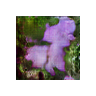

In [ ]:
import IPython
IPython.display.Image('/content/drive/My Drive/102flowers/102flowers/generated_test_output/test-18.png')

In [ ]:
test_image("the petals on this flower are white with an elaborate pistil.",19)

 
 
 
 
 
 
 
 
 
 
1/1 [==============================] - 0s 33ms/step


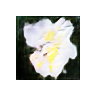

In [ ]:
import IPython
IPython.display.Image('/content/drive/My Drive/102flowers/102flowers/generated_test_output/test-19.png')

In [ ]:
test_image("This is a red flower.",20)

 
 
 
 
1/1 [==============================] - 0s 129ms/step


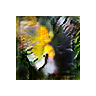

In [ ]:
import IPython
IPython.display.Image('/content/drive/My Drive/102flowers/102flowers/generated_test_output/test-20.png')

In [ ]:
test_image("a flower that has vivid yellow petals and dark purple stamen",21)

 
 
 
 
 
 
 
 
 
 
1/1 [==============================] - 0s 26ms/step


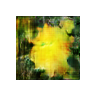

In [ ]:
import IPython
IPython.display.Image('/content/drive/My Drive/102flowers/102flowers/generated_test_output/test-21.png')

In [ ]:
test_image("this is a blue flower with round petals",24)

 
 
 
 
 
 
 
1/1 [==============================] - 0s 32ms/step


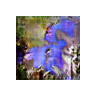

In [ ]:
import IPython
IPython.display.Image('/content/drive/My Drive/102flowers/102flowers/generated_test_output/test-24.png')